In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pickle

In [2]:
# reading input data 


with open('../datasets/question_titles_vec.pickle', 'rb') as f:
    X_t = pickle.load(f)
    
with open('../datasets/questions_vec.pickle', 'rb') as f:
    X_q = pickle.load(f)
    
with open('../datasets/answers_vec.pickle', 'rb') as f:
    X_a = pickle.load(f)

In [3]:
X_t.shape, X_q.shape, X_a.shape

((6076, 32, 300), (6076, 500, 300), (6076, 500, 300))

In [4]:
data = pd.read_pickle('../datasets/train_processed.pickle')

In [5]:
target_names = data.columns[3:-3].copy()

y = data[data.columns[3:-3]].values.copy()
y.shape

(6076, 30)

In [6]:
# train test split
from sklearn.model_selection import train_test_split

X_t_train, X_t_test, y_train, y_test = train_test_split(X_t, y, test_size=0.2, random_state=42)
X_q_train, X_q_test, y_train, y_test = train_test_split(X_q, y, test_size=0.2, random_state=42)
X_a_train, X_a_test, y_train, y_test = train_test_split(X_a, y, test_size=0.2, random_state=42)

In [7]:
X_q_train.shape

(4860, 500, 300)

# Utility functions

In [8]:
from scipy.stats import spearmanr
from sklearn.metrics import mean_squared_error as mse

def print_cors_mse(target_names, preds, reals):
    cors = []
    mses = []
    for i in range(len(target_names)):
        name = target_names[i]
        name = name + ':'
        if len(name)<40:
            name = name + ' '*(40-len(name))
        print(name, f'cor: {np.round(spearmanr(preds[:,i],reals[:,i]).correlation,3)},    mse: {np.round(mse(preds[:,i],reals[:,i]),3)}')
        cors.append(spearmanr(preds[:,i],reals[:,i]).correlation)
        mses.append(mse(preds[:,i],reals[:,i]))
    print('\n\n CORRELATION STATS: \n', pd.Series(cors).describe())
    print('\n\n MSE STATS: \n', pd.Series(mses).describe())

In [9]:
def plot_cors_mse(target_names, preds, reals):
    cors = []
    mses = []
    for i in range(len(target_names)):
        cors.append(spearmanr(preds[:,i],reals[:,i]).correlation)
        mses.append(mse(preds[:,i],reals[:,i]))
    plt.figure(figsize=(20,7))
    plt.subplot(1,2,1)
    plt.bar(target_names, cors)
    plt.xticks(rotation=90)
    plt.title('CORS')
    plt.subplot(1,2,2)
    plt.bar(target_names, mses)
    plt.xticks(rotation=90)
    plt.title('MSEs')

In [10]:
# scatterplots

def scatterplots(target_names, preds, reals):
    plt.figure(figsize=(25,35))
    for i in range(len(target_names)):
        plt.subplot(10,3,i+1)
        plt.scatter(preds[:,i],reals[:,i])
        plt.title(target_names[i])
        plt.tight_layout()
    plt.show()

In [11]:
earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.005, patience=20, restore_best_weights=True)

In [12]:
import tensorflow.keras.backend as K

class attention_many_to_one(keras.layers.Layer):

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        #super().build(input_shape)

    def call(self,x):
        # like time-distributed dense
        # each time point has 64 features
        # takes dot of features with weights (weights have dim 64)
        # returns vector of len 30 - for each timepoint, just one value is returned
        # squeezed from (30,1) to 30
        dots=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        softmax_weights=K.softmax(dots)
        softmax_weights=K.expand_dims(softmax_weights,axis=-1)
        # each time point is miltiplied by corresponding scalar
        # this gives greater weight to more important words in output sequence
        output=x*softmax_weights
        # all 30 time ponts are summed to get just one vector of dim 64
        return K.sum(output,axis=1)

# LSTM Model

In [10]:
input_q = keras.layers.Input(shape=(500,300))
x_q = keras.layers.Bidirectional(keras.layers.LSTM(64, dropout=0.3))(input_q)

input_a = keras.layers.Input(shape=(500,300))
x_a = keras.layers.Bidirectional(keras.layers.LSTM(64, dropout=0.3))(input_a)

x = keras.layers.concatenate((x_q, x_a))

x = keras.layers.Dense(64, activity_regularizer='l2')(x)
x = keras.layers.LeakyReLU(0.5)(x)
output = keras.layers.Dense(30, activation=keras.activations.hard_sigmoid)(x)

model = keras.Model([input_q, input_a], output)

model.compile(optimizer = 'adam', loss = 'mse')

In [17]:
earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.005, patience=20, restore_best_weights=True)

In [13]:
model.fit([X_q_train, X_a_train], y_train, batch_size=145, epochs=500, callbacks=[earlystopping], validation_data=([X_q_test, X_a_test], y_test))

Epoch 1/500
34/34 [==============================] - 10s 297ms/step - loss: 0.1538 - val_loss: 0.1391
Epoch 2/500
34/34 [==============================] - 8s 232ms/step - loss: 0.1255 - val_loss: 0.1146
Epoch 3/500
34/34 [==============================] - 8s 236ms/step - loss: 0.1058 - val_loss: 0.0998
Epoch 4/500
34/34 [==============================] - 8s 235ms/step - loss: 0.0940 - val_loss: 0.0907
Epoch 5/500
34/34 [==============================] - 8s 234ms/step - loss: 0.0863 - val_loss: 0.0850
Epoch 6/500
34/34 [==============================] - 8s 237ms/step - loss: 0.0810 - val_loss: 0.0807
Epoch 7/500
34/34 [==============================] - 8s 236ms/step - loss: 0.0770 - val_loss: 0.0772
Epoch 8/500
34/34 [==============================] - 8s 236ms/step - loss: 0.0738 - val_loss: 0.0746
Epoch 9/500
34/34 [==============================] - 8s 237ms/step - loss: 0.0715 - val_loss: 0.0723
Epoch 10/500
34/34 [==============================] - 8s 237ms/step - loss: 0.0694 - val_l

In [17]:
preds_train = model.predict([X_q_train, X_a_train])
preds_test = model.predict([X_q_test, X_a_test])

In [18]:
print_cors_mse(target_names, preds_test, y_test)

question_asker_intent_understanding:     cor: 0.216,    mse: 0.016
question_body_critical:                  cor: 0.291,    mse: 0.044
question_conversational:                 cor: 0.39,    mse: 0.029
question_expect_short_answer:            cor: 0.117,    mse: 0.123
question_fact_seeking:                   cor: 0.216,    mse: 0.081
question_has_commonly_accepted_answer:   cor: 0.384,    mse: 0.094
question_interestingness_others:         cor: 0.335,    mse: 0.017
question_interestingness_self:           cor: 0.425,    mse: 0.029
question_multi_intent:                   cor: 0.237,    mse: 0.106
question_not_really_a_question:          cor: -0.005,    mse: 0.004
question_opinion_seeking:                cor: 0.278,    mse: 0.125
question_type_choice:                    cor: 0.297,    mse: 0.127
question_type_compare:                   cor: 0.259,    mse: 0.029
question_type_consequence:               cor: 0.04,    mse: 0.007
question_type_definition:                cor: 0.222,    mse: 0.

In [19]:
print_cors_mse(target_names, preds_train, y_train)

question_asker_intent_understanding:     cor: 0.339,    mse: 0.016
question_body_critical:                  cor: 0.346,    mse: 0.042
question_conversational:                 cor: 0.414,    mse: 0.025
question_expect_short_answer:            cor: 0.235,    mse: 0.116
question_fact_seeking:                   cor: 0.366,    mse: 0.076
question_has_commonly_accepted_answer:   cor: 0.459,    mse: 0.084
question_interestingness_others:         cor: 0.33,    mse: 0.016
question_interestingness_self:           cor: 0.453,    mse: 0.027
question_multi_intent:                   cor: 0.355,    mse: 0.099
question_not_really_a_question:          cor: 0.05,    mse: 0.004
question_opinion_seeking:                cor: 0.457,    mse: 0.109
question_type_choice:                    cor: 0.43,    mse: 0.114
question_type_compare:                   cor: 0.246,    mse: 0.021
question_type_consequence:               cor: 0.129,    mse: 0.007
question_type_definition:                cor: 0.204,    mse: 0.01

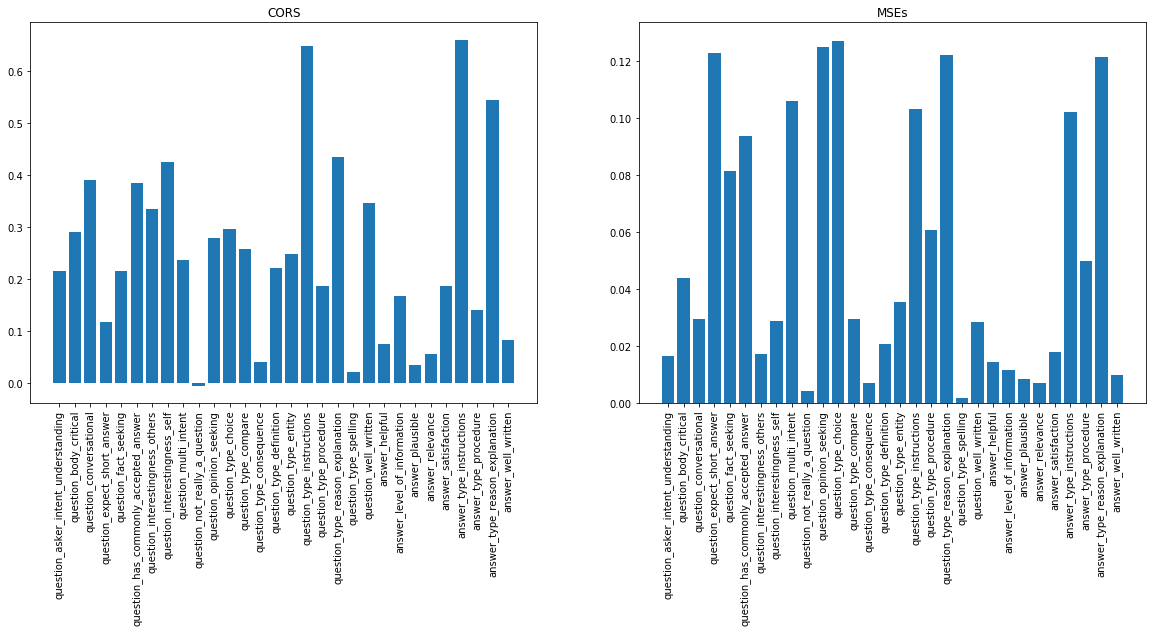

In [20]:
plot_cors_mse(target_names, preds_test, y_test)

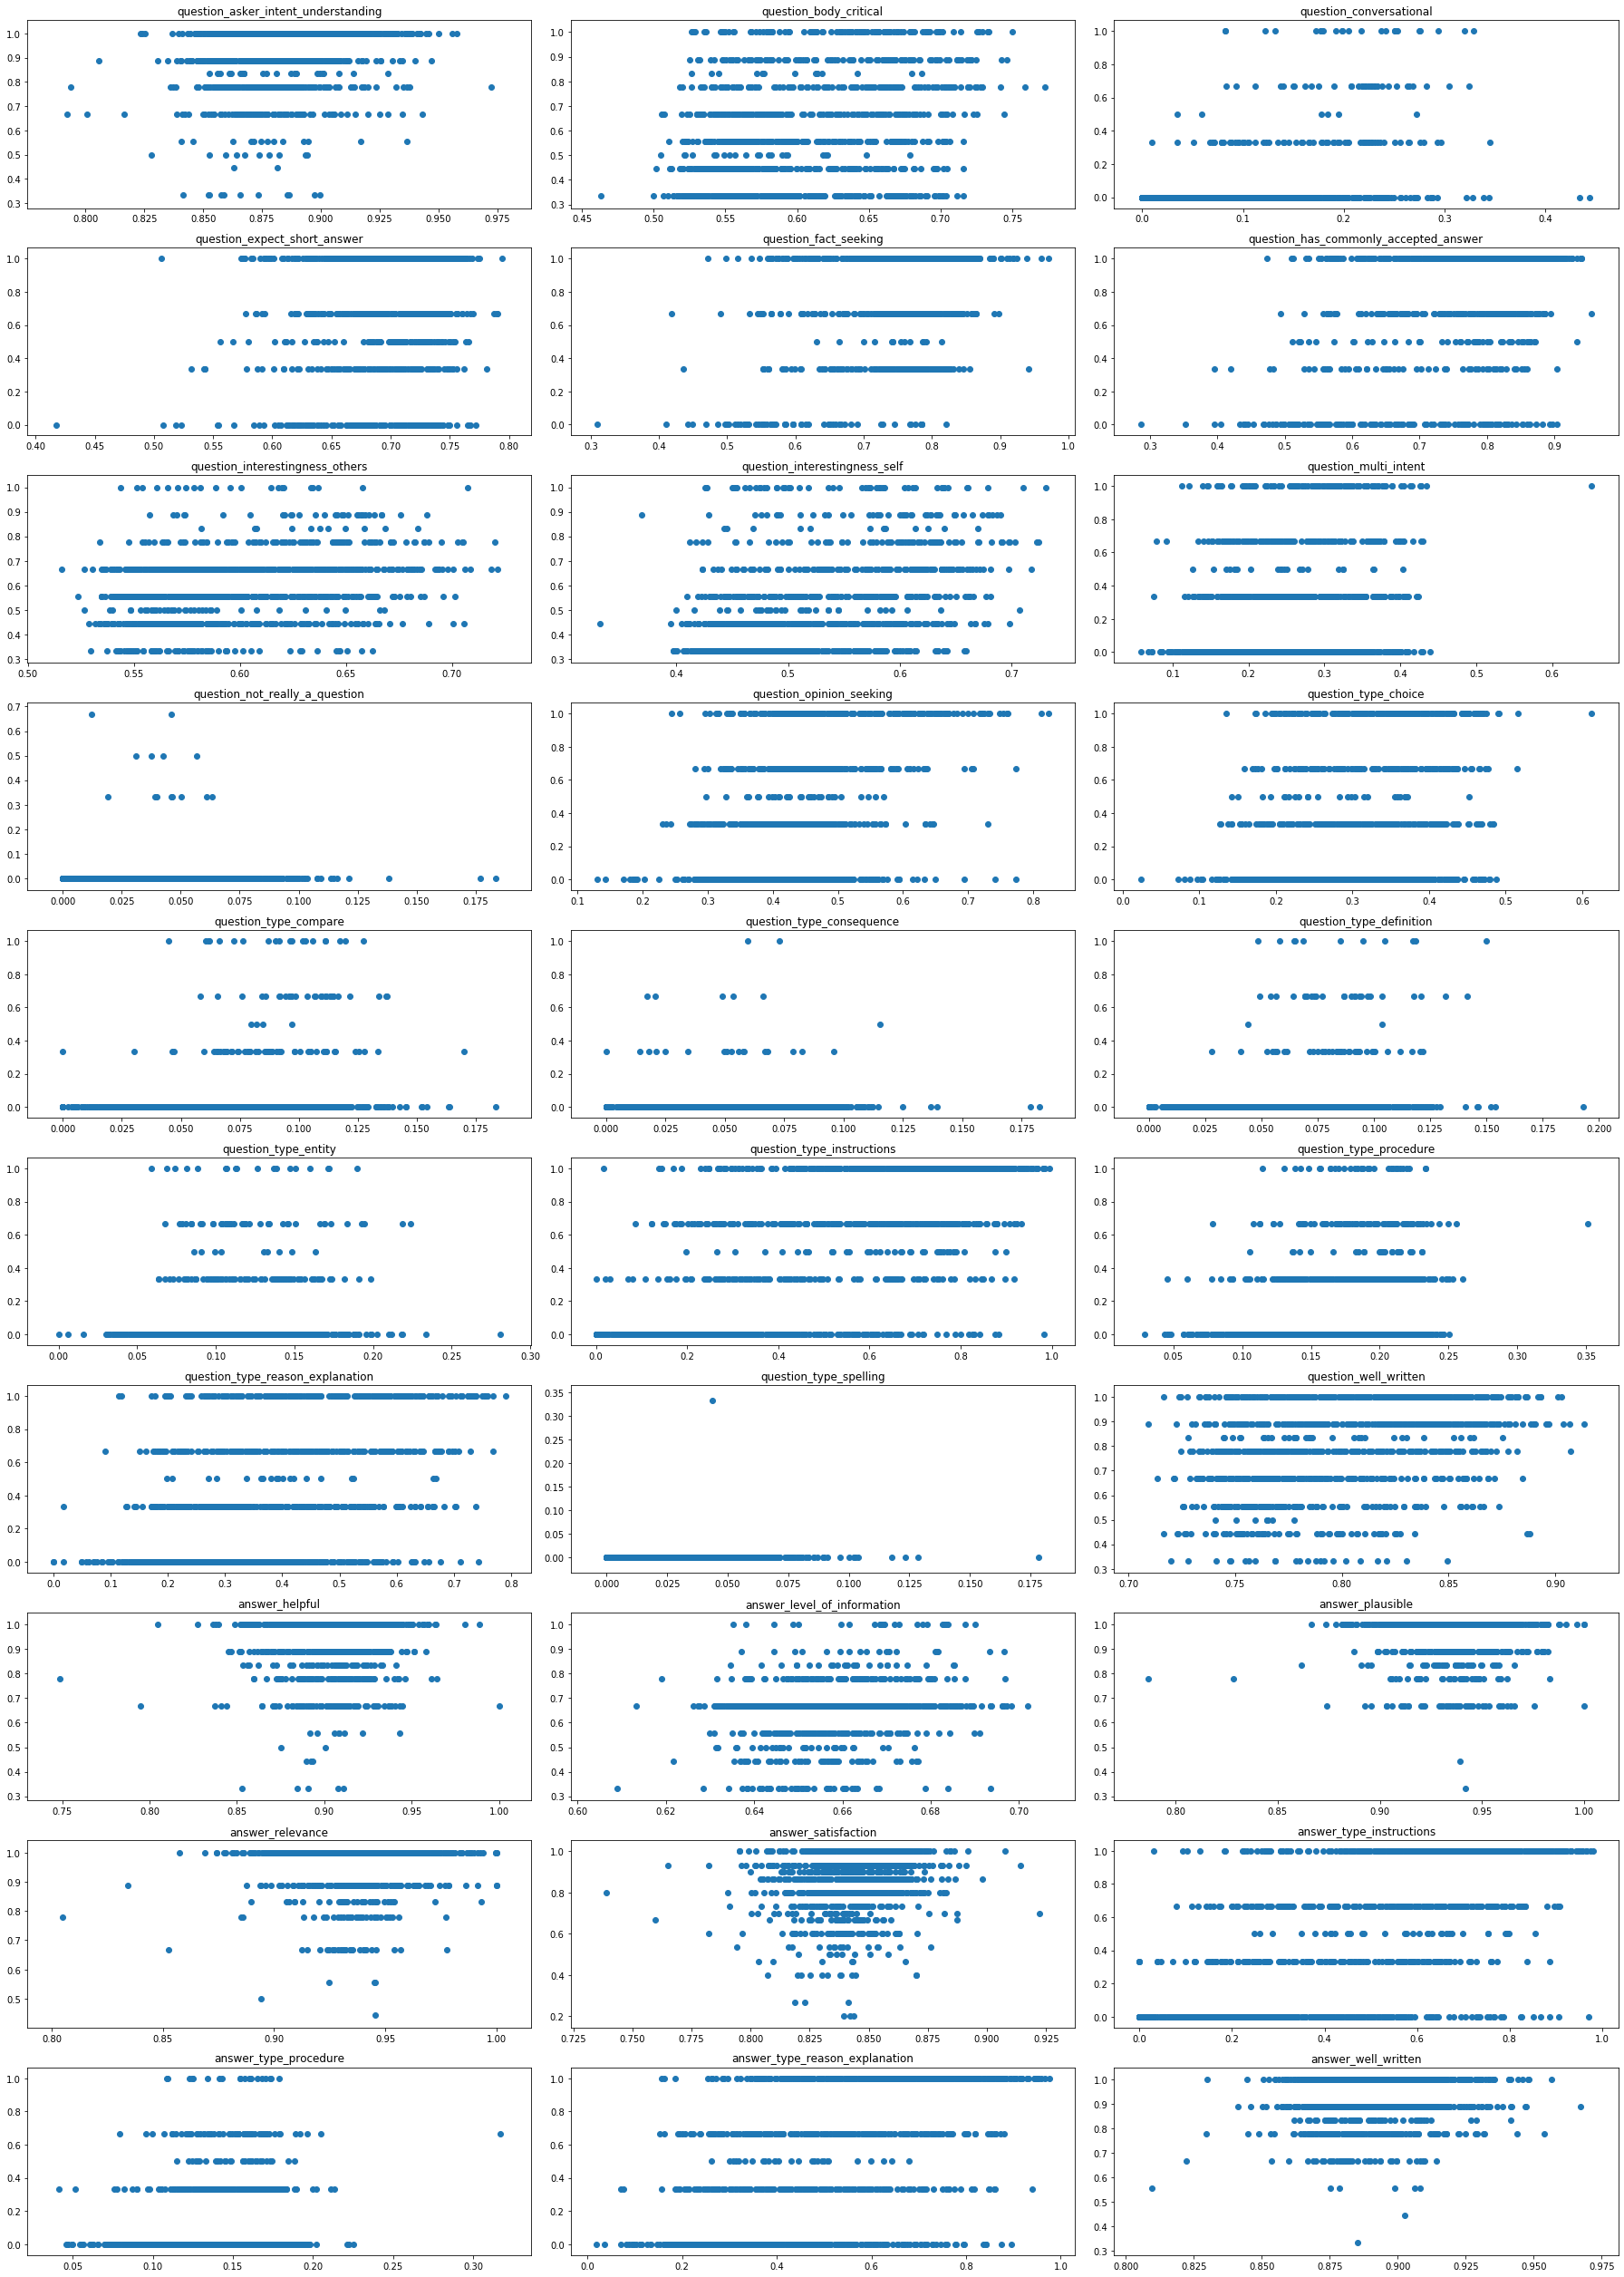

In [21]:
scatterplots(target_names, preds_test, y_test)

# Adding attention

In [22]:
input_q = keras.layers.Input(shape=(500,300))
x_q = keras.layers.Attention()([input_q,input_q])
x_q = keras.layers.Bidirectional(keras.layers.LSTM(64, dropout=0.3))(x_q)

input_a = keras.layers.Input(shape=(500,300))
x_a = keras.layers.Attention()([input_a,input_a])
x_a = keras.layers.Bidirectional(keras.layers.LSTM(64, dropout=0.3))(x_a)

x = keras.layers.concatenate((x_q, x_a))

x = keras.layers.Dense(64, activity_regularizer='l2')(x)
x = keras.layers.LeakyReLU(0.5)(x)
output = keras.layers.Dense(30, activation=keras.activations.hard_sigmoid)(x)

model = keras.Model([input_q, input_a], output)

model.compile(optimizer = 'adam', loss = 'mse')

In [23]:
model.fit([X_q_train, X_a_train], y_train, batch_size=145, epochs=500, callbacks=[earlystopping], validation_data=([X_q_test, X_a_test], y_test))

Epoch 1/500
34/34 [==============================] - 13s 373ms/step - loss: 0.1567 - val_loss: 0.1422
Epoch 2/500
34/34 [==============================] - 11s 328ms/step - loss: 0.1270 - val_loss: 0.1149
Epoch 3/500
34/34 [==============================] - 11s 336ms/step - loss: 0.1054 - val_loss: 0.0989
Epoch 4/500
34/34 [==============================] - 11s 313ms/step - loss: 0.0929 - val_loss: 0.0895
Epoch 5/500
34/34 [==============================] - 11s 330ms/step - loss: 0.0850 - val_loss: 0.0833
Epoch 6/500
34/34 [==============================] - 11s 318ms/step - loss: 0.0798 - val_loss: 0.0789
Epoch 7/500
34/34 [==============================] - 11s 311ms/step - loss: 0.0758 - val_loss: 0.0757
Epoch 8/500
34/34 [==============================] - 11s 312ms/step - loss: 0.0728 - val_loss: 0.0733
Epoch 9/500
34/34 [==============================] - 11s 319ms/step - loss: 0.0706 - val_loss: 0.0714
Epoch 10/500
34/34 [==============================] - 11s 321ms/step - loss: 0.068

In [24]:
preds_train = model.predict([X_q_train, X_a_train])
preds_test = model.predict([X_q_test, X_a_test])

In [26]:
print_cors_mse(target_names, preds_test, y_test)

question_asker_intent_understanding:     cor: 0.209,    mse: 0.017
question_body_critical:                  cor: 0.382,    mse: 0.041
question_conversational:                 cor: 0.407,    mse: 0.029
question_expect_short_answer:            cor: 0.199,    mse: 0.12
question_fact_seeking:                   cor: 0.22,    mse: 0.081
question_has_commonly_accepted_answer:   cor: 0.397,    mse: 0.092
question_interestingness_others:         cor: 0.335,    mse: 0.017
question_interestingness_self:           cor: 0.407,    mse: 0.029
question_multi_intent:                   cor: 0.356,    mse: 0.098
question_not_really_a_question:          cor: 0.009,    mse: 0.004
question_opinion_seeking:                cor: 0.349,    mse: 0.121
question_type_choice:                    cor: 0.267,    mse: 0.13
question_type_compare:                   cor: 0.19,    mse: 0.03
question_type_consequence:               cor: 0.021,    mse: 0.008
question_type_definition:                cor: 0.258,    mse: 0.02
q

In [27]:
print_cors_mse(target_names, preds_train, y_train)

question_asker_intent_understanding:     cor: 0.314,    mse: 0.016
question_body_critical:                  cor: 0.416,    mse: 0.039
question_conversational:                 cor: 0.4,    mse: 0.027
question_expect_short_answer:            cor: 0.259,    mse: 0.115
question_fact_seeking:                   cor: 0.327,    mse: 0.079
question_has_commonly_accepted_answer:   cor: 0.44,    mse: 0.087
question_interestingness_others:         cor: 0.343,    mse: 0.016
question_interestingness_self:           cor: 0.452,    mse: 0.027
question_multi_intent:                   cor: 0.453,    mse: 0.092
question_not_really_a_question:          cor: 0.012,    mse: 0.004
question_opinion_seeking:                cor: 0.453,    mse: 0.109
question_type_choice:                    cor: 0.358,    mse: 0.121
question_type_compare:                   cor: 0.212,    mse: 0.022
question_type_consequence:               cor: 0.074,    mse: 0.008
question_type_definition:                cor: 0.264,    mse: 0.01

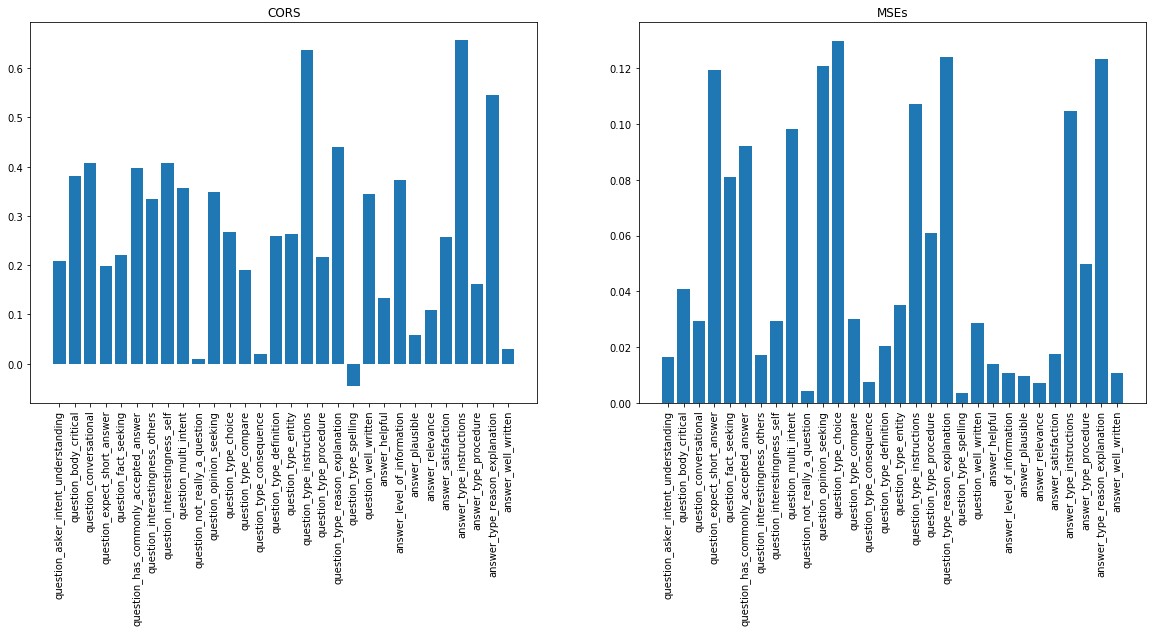

In [28]:
plot_cors_mse(target_names, preds_test, y_test)

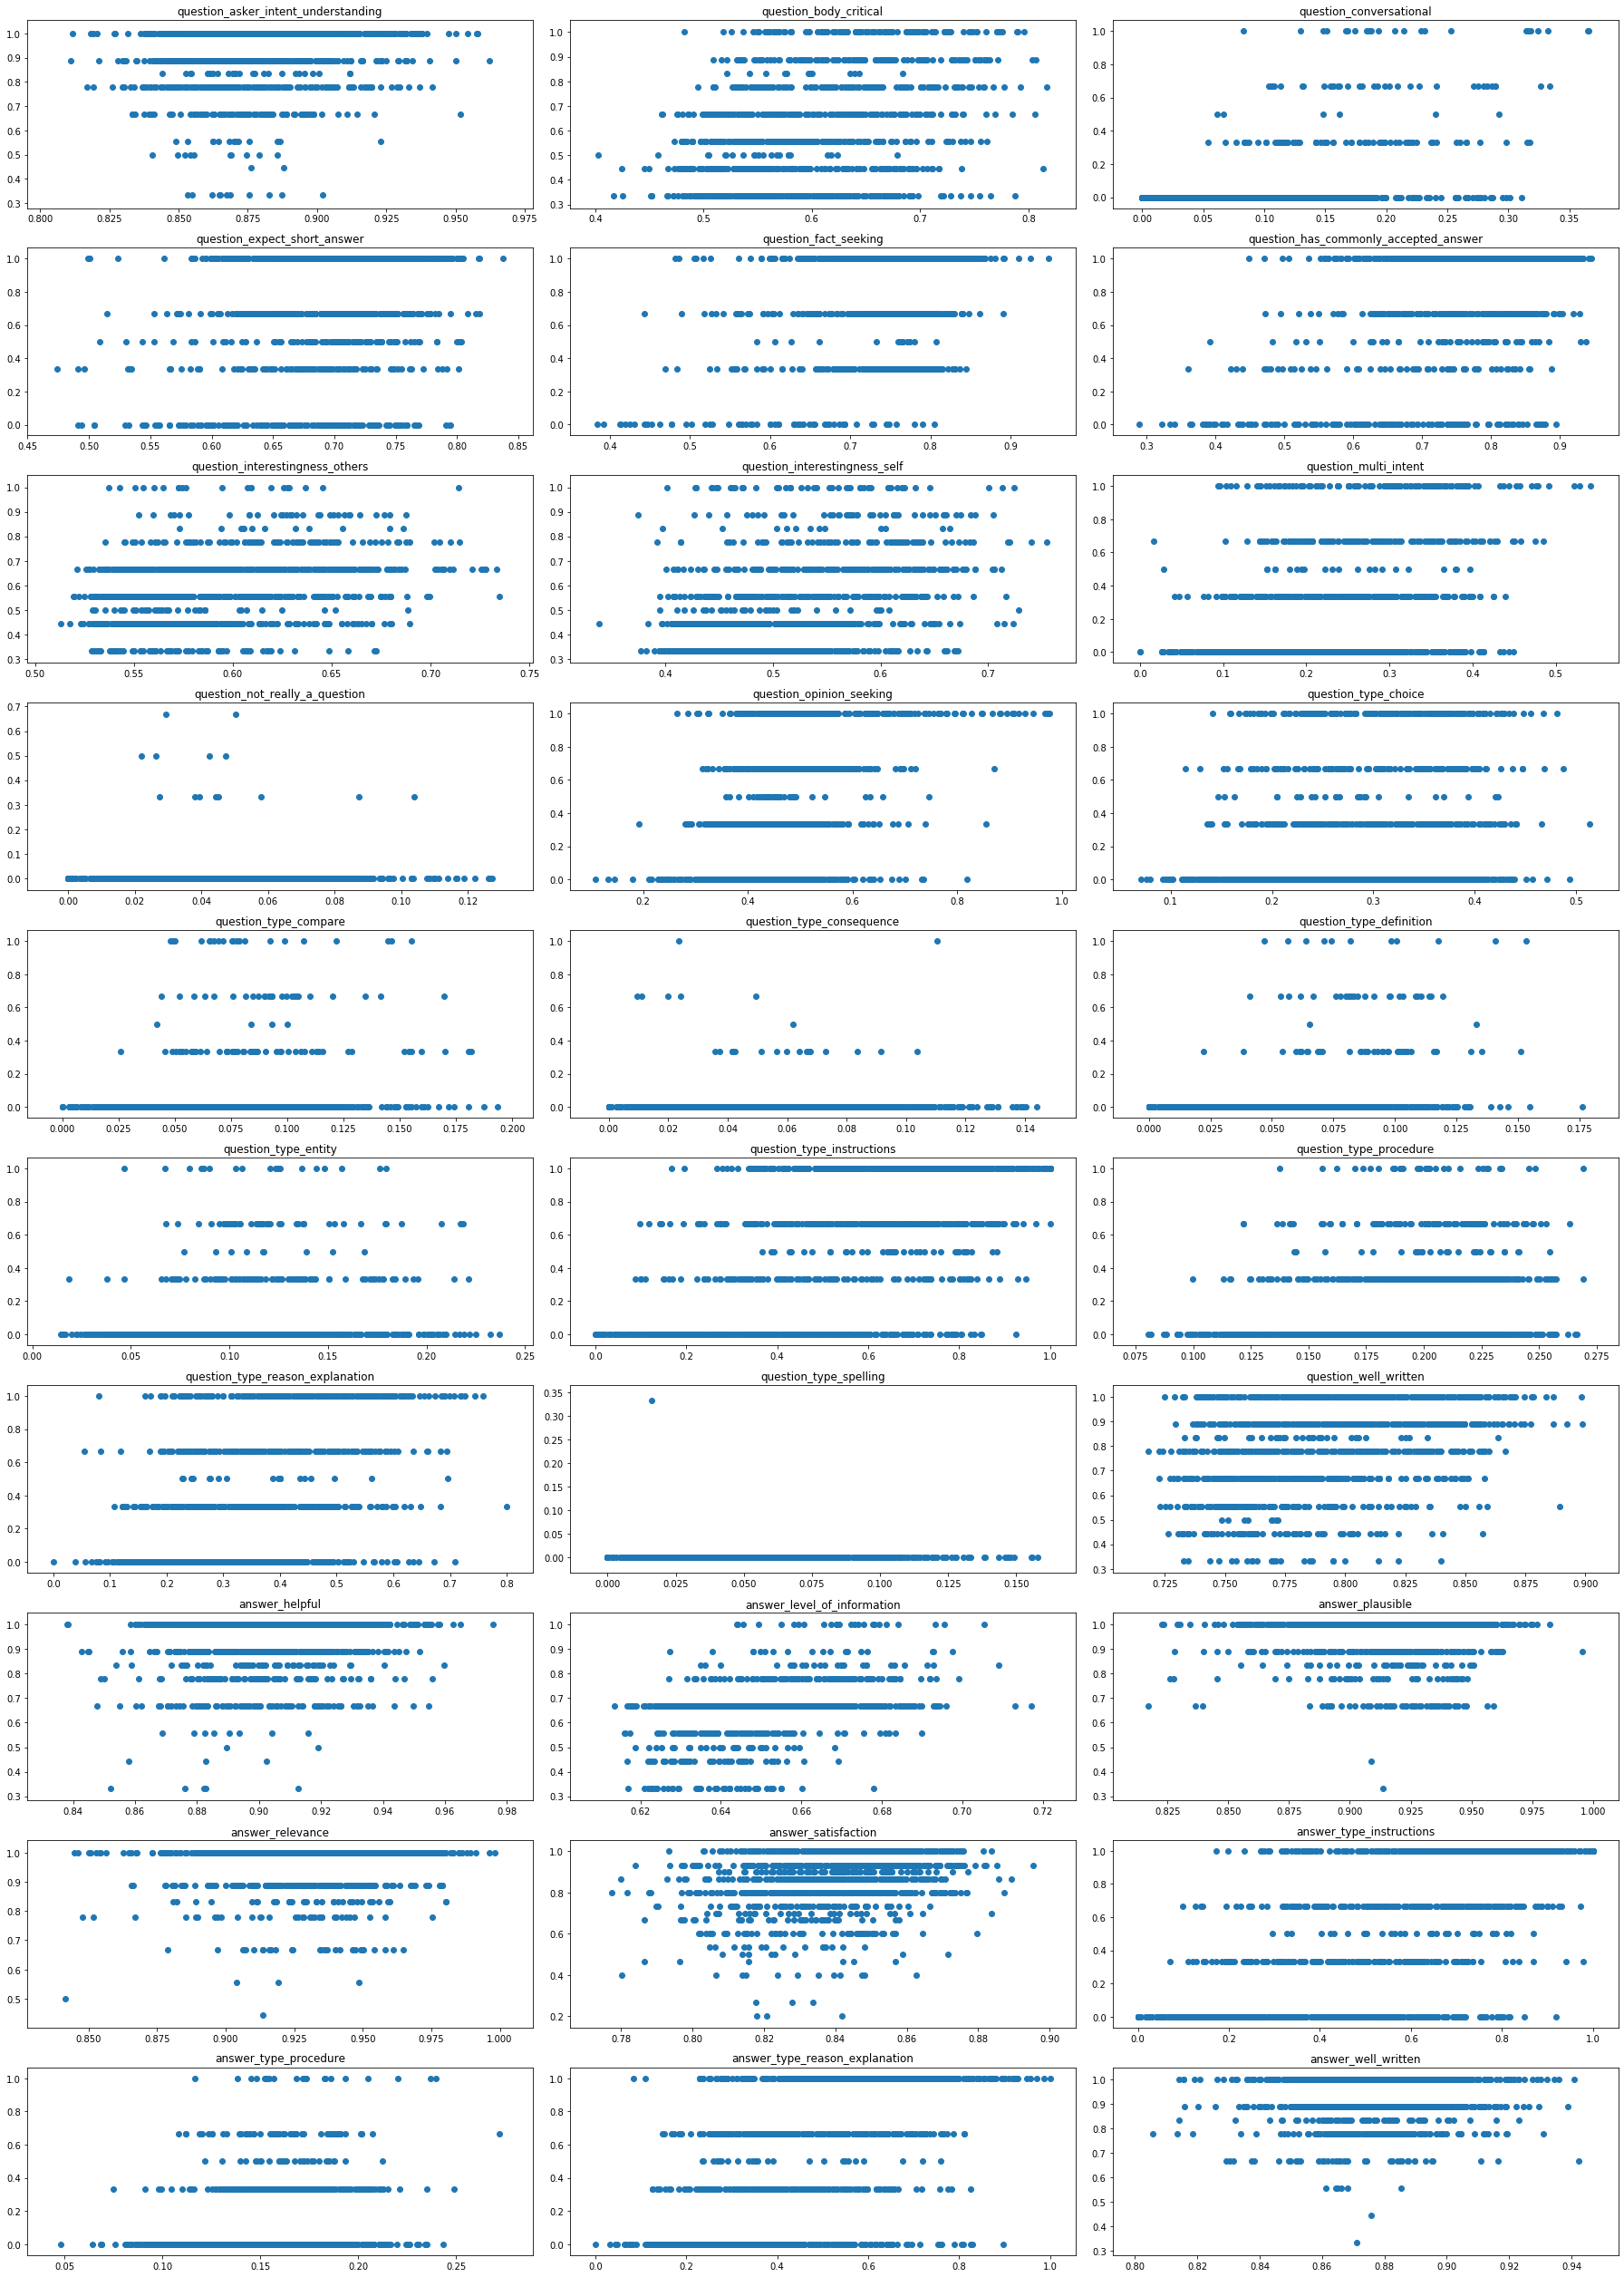

In [29]:
scatterplots(target_names, preds_test, y_test)

# SElf attention, many to one attention

In [14]:
input_q = keras.layers.Input(shape=(500,300))
x_q = keras.layers.Attention()([input_q,input_q])
x_q = keras.layers.Bidirectional(keras.layers.LSTM(128, dropout=0.3, return_sequences=True))(x_q)

input_a = keras.layers.Input(shape=(500,300))
x_a = keras.layers.Attention()([input_a,input_a])
x_a = keras.layers.Bidirectional(keras.layers.LSTM(128, dropout=0.3, return_sequences=True))(x_a)

x = keras.layers.concatenate((x_q, x_a))

x = keras.layers.Dense(256, activity_regularizer='l2')(x)
x = keras.layers.LeakyReLU(0.5)(x)
x = keras.layers.BatchNormalization()(x)

x = attention_many_to_one()(x)

output = keras.layers.Dense(30, activation=keras.activations.hard_sigmoid)(x)

model = keras.Model([input_q, input_a], output)

model.compile(optimizer = 'adam', loss = 'mse')

In [18]:
model.fit([X_q_train, X_a_train], y_train, batch_size=145, epochs=500, callbacks=[earlystopping], validation_data=([X_q_test, X_a_test], y_test))

Epoch 1/500
34/34 [==============================] - 22s 653ms/step - loss: 0.3553 - val_loss: 0.1754
Epoch 2/500
34/34 [==============================] - 19s 567ms/step - loss: 0.1537 - val_loss: 0.0911
Epoch 3/500
34/34 [==============================] - 19s 561ms/step - loss: 0.0948 - val_loss: 0.0765
Epoch 4/500
34/34 [==============================] - 19s 565ms/step - loss: 0.0816 - val_loss: 0.0730
Epoch 5/500
34/34 [==============================] - 19s 566ms/step - loss: 0.0743 - val_loss: 0.0707
Epoch 6/500
34/34 [==============================] - 20s 598ms/step - loss: 0.0692 - val_loss: 0.0690
Epoch 7/500
34/34 [==============================] - 20s 592ms/step - loss: 0.0653 - val_loss: 0.0674
Epoch 8/500
34/34 [==============================] - 20s 587ms/step - loss: 0.0624 - val_loss: 0.0665
Epoch 9/500
34/34 [==============================] - 20s 593ms/step - loss: 0.0602 - val_loss: 0.0652
Epoch 10/500
34/34 [==============================] - 20s 585ms/step - loss: 0.058

In [19]:
preds_train = model.predict([X_q_train, X_a_train])
preds_test = model.predict([X_q_test, X_a_test])

In [20]:
print_cors_mse(target_names, preds_test, y_test)

question_asker_intent_understanding:     cor: 0.26,    mse: 0.016
question_body_critical:                  cor: 0.391,    mse: 0.042
question_conversational:                 cor: 0.427,    mse: 0.028
question_expect_short_answer:            cor: 0.196,    mse: 0.121
question_fact_seeking:                   cor: 0.238,    mse: 0.08
question_has_commonly_accepted_answer:   cor: 0.379,    mse: 0.095
question_interestingness_others:         cor: 0.35,    mse: 0.017
question_interestingness_self:           cor: 0.43,    mse: 0.03
question_multi_intent:                   cor: 0.413,    mse: 0.097
question_not_really_a_question:          cor: 0.047,    mse: 0.002
question_opinion_seeking:                cor: 0.337,    mse: 0.122
question_type_choice:                    cor: 0.386,    mse: 0.124
question_type_compare:                   cor: 0.285,    mse: 0.03
question_type_consequence:               cor: -0.01,    mse: 0.005
question_type_definition:                cor: 0.322,    mse: 0.019
q

/usr/anaconda/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/anaconda/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/anaconda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/anaconda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/anaconda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/anaconda/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/anaconda/lib/python3.7/site-packages

In [21]:
print_cors_mse(target_names, preds_train, y_train)

question_asker_intent_understanding:     cor: 0.373,    mse: 0.016
question_body_critical:                  cor: 0.465,    mse: 0.04
question_conversational:                 cor: 0.424,    mse: 0.026
question_expect_short_answer:            cor: 0.337,    mse: 0.113
question_fact_seeking:                   cor: 0.355,    mse: 0.077
question_has_commonly_accepted_answer:   cor: 0.45,    mse: 0.089
question_interestingness_others:         cor: 0.38,    mse: 0.016
question_interestingness_self:           cor: 0.497,    mse: 0.028
question_multi_intent:                   cor: 0.543,    mse: 0.089
question_not_really_a_question:          cor: -0.009,    mse: 0.002
question_opinion_seeking:                cor: 0.448,    mse: 0.11
question_type_choice:                    cor: 0.475,    mse: 0.115
question_type_compare:                   cor: 0.291,    mse: 0.02
question_type_consequence:               cor: 0.135,    mse: 0.006
question_type_definition:                cor: 0.315,    mse: 0.017

/usr/anaconda/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/anaconda/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/anaconda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/anaconda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/anaconda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


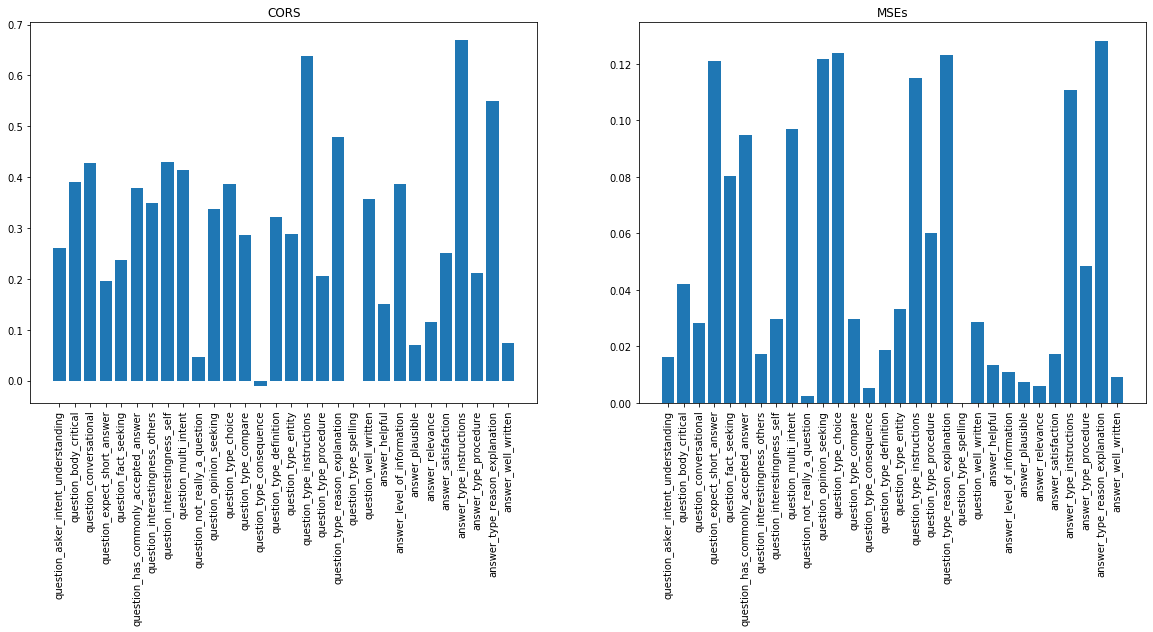

In [22]:
plot_cors_mse(target_names, preds_test, y_test)

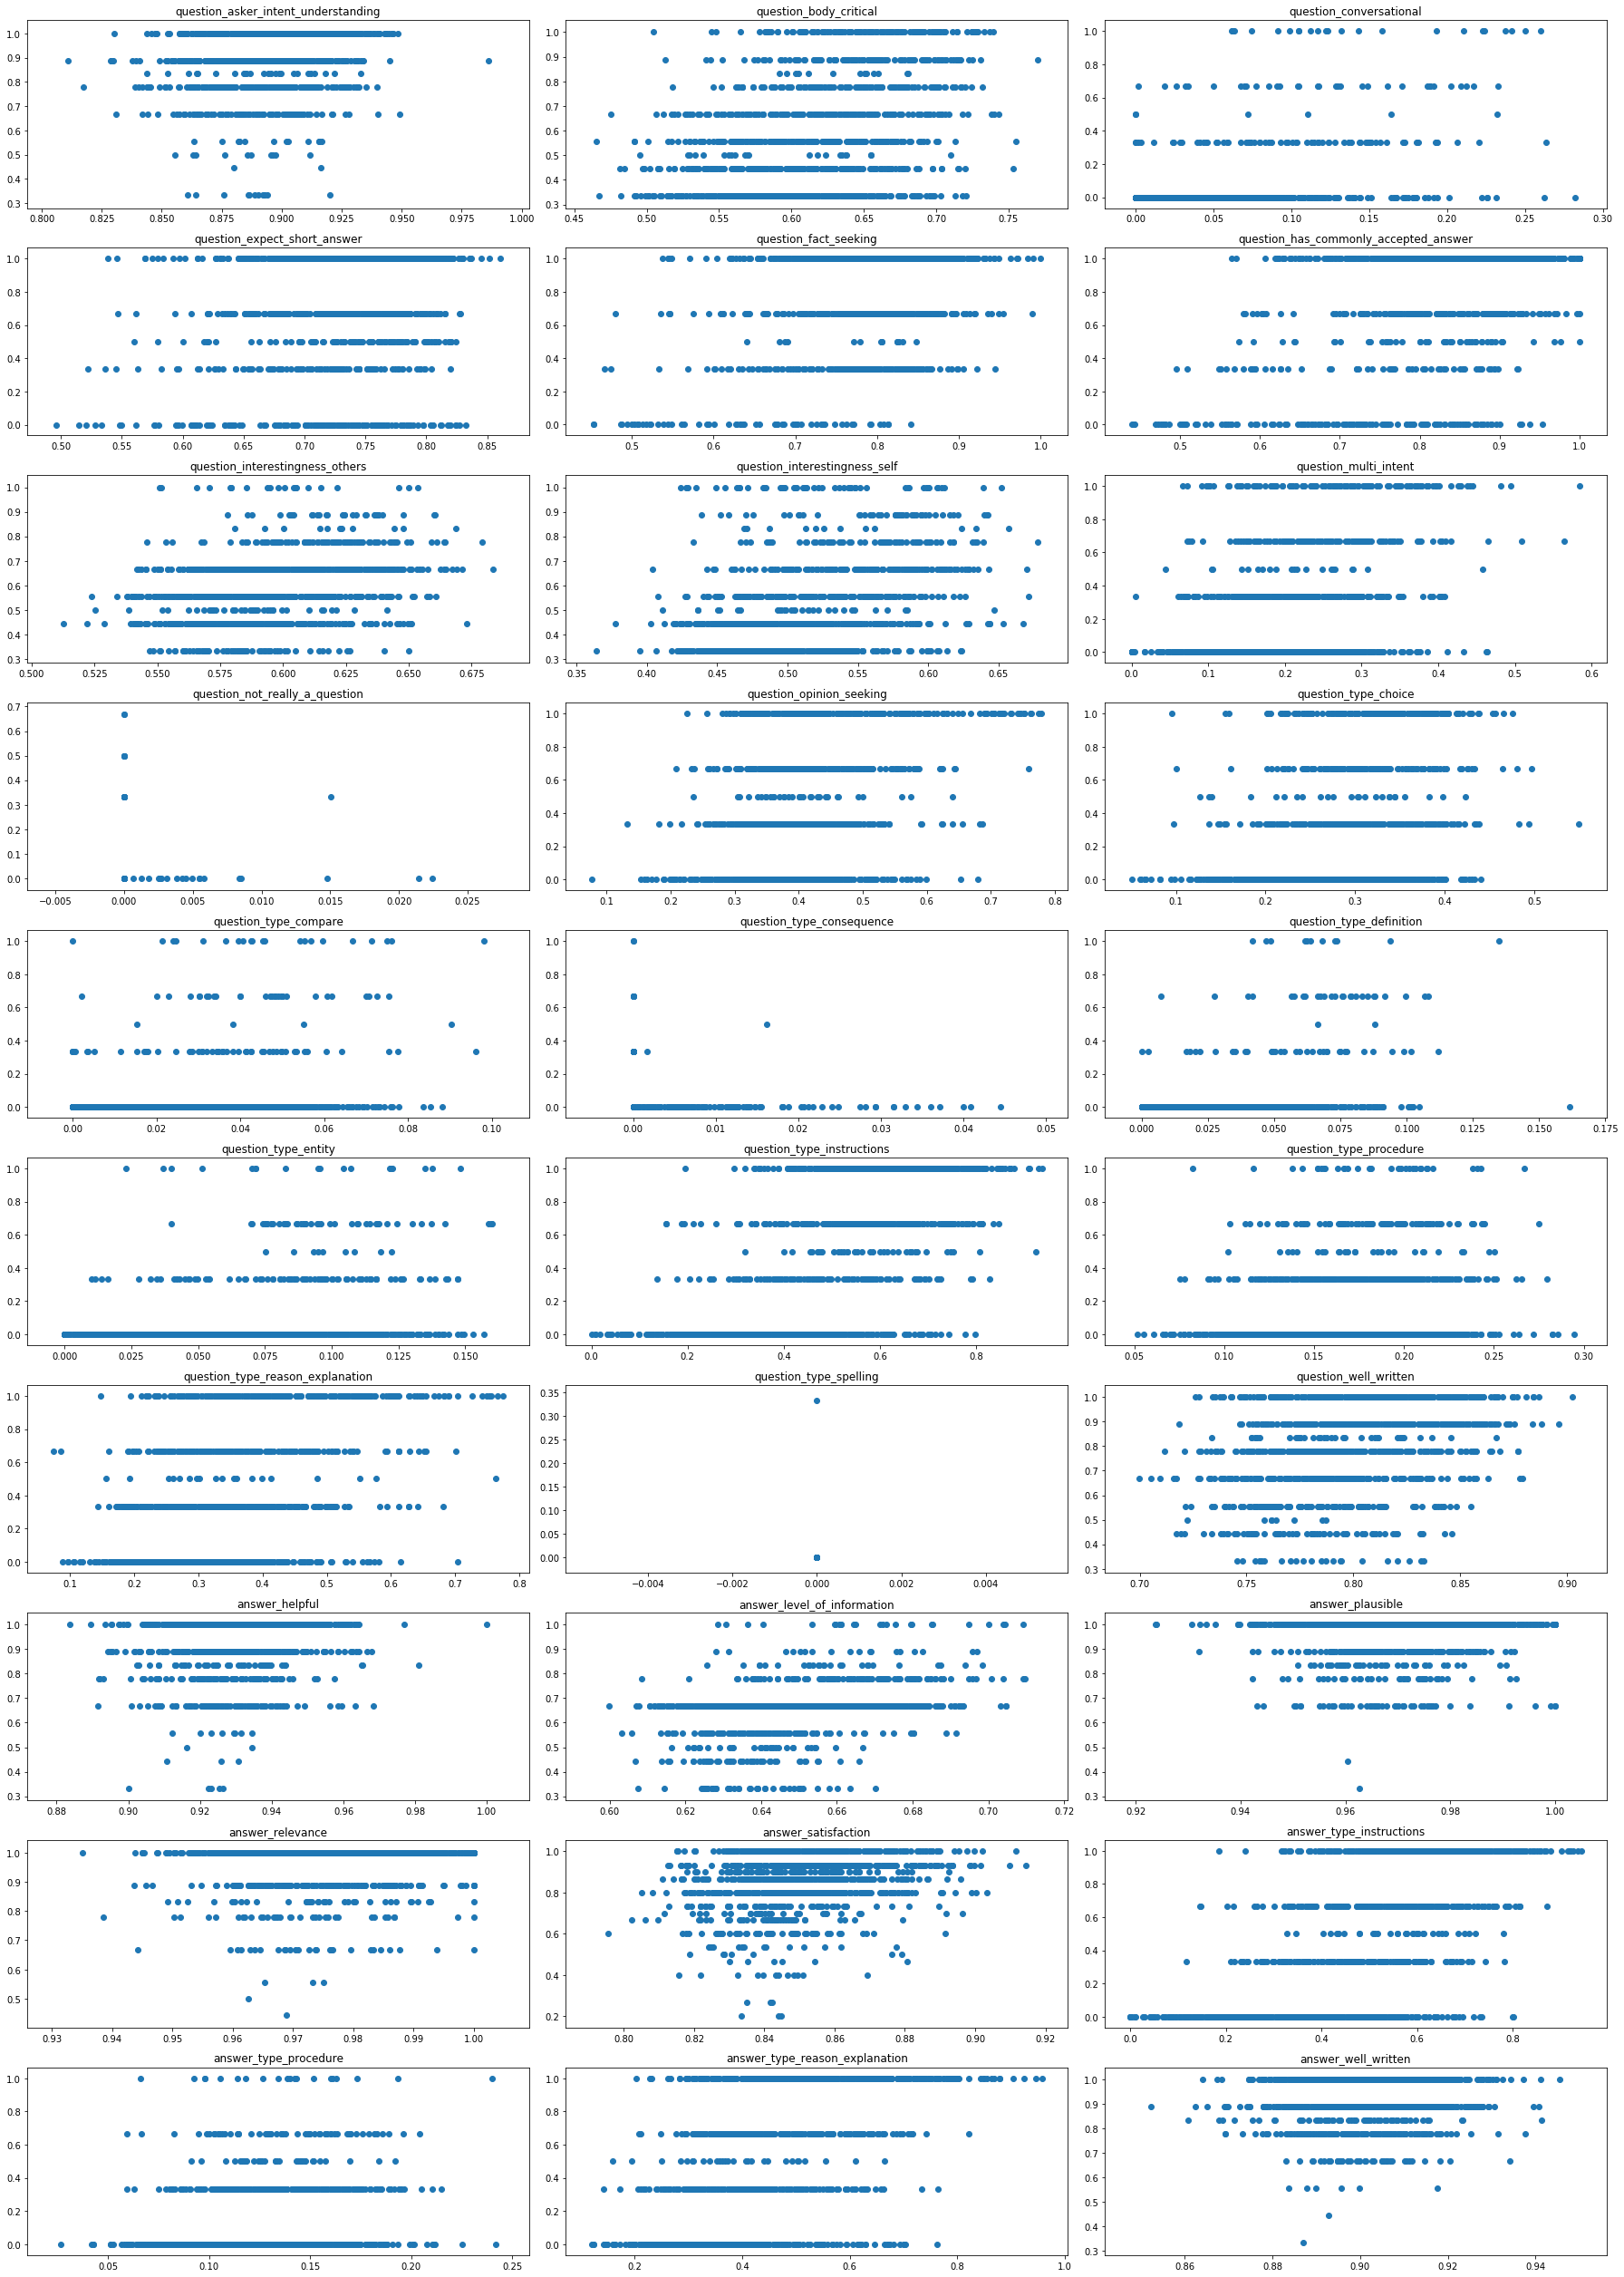

In [23]:
scatterplots(target_names, preds_test, y_test)

# Separating titles, questions and asnwers

In [13]:
input_t = keras.layers.Input(shape=(32,300))
x_t = keras.layers.Attention()([input_t,input_t])
x_t = keras.layers.Masking()(x_t)
x_t = keras.layers.Bidirectional(keras.layers.LSTM(64, dropout=0.3, return_sequences=True, activity_regularizer='l2'))(x_t)
x_t = attention_many_to_one()(x_t)
x_t = keras.layers.BatchNormalization()(x_t)
x_t = keras.layers.Dropout(0.3)(x_t)
x_t = keras.layers.Dense(30, activity_regularizer='l2', activation=keras.activations.swish)(x_t)

input_q = keras.layers.Input(shape=(500,300))
x_q = keras.layers.Attention()([input_q,input_q])
x_q = keras.layers.Masking()(x_q)
x_q = keras.layers.Bidirectional(keras.layers.LSTM(64, dropout=0.3, return_sequences=True, activity_regularizer='l2'))(x_q)
x_q = attention_many_to_one()(x_q)
x_q = keras.layers.BatchNormalization()(x_q)
x_q = keras.layers.Dropout(0.3)(x_q)
x_q = keras.layers.Dense(70, activity_regularizer='l2', activation=keras.activations.swish)(x_q)


input_a = keras.layers.Input(shape=(500,300))
x_a = keras.layers.Attention()([input_a,input_a])
x_a = keras.layers.Masking()(x_a)
x_a = keras.layers.Bidirectional(keras.layers.LSTM(64, dropout=0.3, return_sequences=True, activity_regularizer='l2'))(x_a)
x_a = attention_many_to_one()(x_a)
x_a = keras.layers.BatchNormalization()(x_a)
x_a = keras.layers.Dropout(0.3)(x_a)
x_a = keras.layers.Dense(70, activity_regularizer='l2', activation=keras.activations.swish)(x_a)


x = keras.layers.concatenate((x_t, x_q, x_a))

output = keras.layers.Dense(30, activation='sigmoid')(x)

model = keras.Model([input_t, input_q, input_a], output)

model.compile(optimizer = 'adam', loss = 'mse')

In [14]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 300)]    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 500, 300)]   0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 500, 300)]   0                                            
__________________________________________________________________________________________________
attention (Attention)           (None, 32, 300)      0           input_1[0][0]                    
                                                                 input_1[0][0]         

In [15]:
model.fit([X_t_train, X_q_train, X_a_train], y_train, batch_size=145, epochs=500, callbacks=[earlystopping], validation_data=([X_t_test, X_q_test, X_a_test], y_test))

Epoch 1/500
34/34 [==============================] - 20s 595ms/step - loss: 0.5159 - val_loss: 0.2130
Epoch 2/500
34/34 [==============================] - 15s 443ms/step - loss: 0.2252 - val_loss: 0.1306
Epoch 3/500
34/34 [==============================] - 15s 444ms/step - loss: 0.1614 - val_loss: 0.1087
Epoch 4/500
34/34 [==============================] - 15s 445ms/step - loss: 0.1345 - val_loss: 0.0977
Epoch 5/500
34/34 [==============================] - 15s 453ms/step - loss: 0.1184 - val_loss: 0.0909
Epoch 6/500
34/34 [==============================] - 16s 468ms/step - loss: 0.1072 - val_loss: 0.0861
Epoch 7/500
34/34 [==============================] - 16s 467ms/step - loss: 0.0988 - val_loss: 0.0825
Epoch 8/500
34/34 [==============================] - 16s 475ms/step - loss: 0.0925 - val_loss: 0.0797
Epoch 9/500
34/34 [==============================] - 16s 461ms/step - loss: 0.0874 - val_loss: 0.0773
Epoch 10/500
34/34 [==============================] - 15s 451ms/step - loss: 0.083

In [16]:
model.save_weights('model_weights.h5')

In [14]:
model.load_weights('model_weights.h5')

In [15]:
preds_train = model.predict([X_t_train, X_q_train, X_a_train])
preds_test = model.predict([X_t_test, X_q_test, X_a_test])

In [16]:
print_cors_mse(target_names, preds_test, y_test)

question_asker_intent_understanding:     cor: 0.221,    mse: 0.017
question_body_critical:                  cor: 0.571,    mse: 0.033
question_conversational:                 cor: 0.397,    mse: 0.031
question_expect_short_answer:            cor: 0.213,    mse: 0.119
question_fact_seeking:                   cor: 0.23,    mse: 0.079
question_has_commonly_accepted_answer:   cor: 0.371,    mse: 0.089
question_interestingness_others:         cor: 0.347,    mse: 0.017
question_interestingness_self:           cor: 0.422,    mse: 0.029
question_multi_intent:                   cor: 0.413,    mse: 0.095
question_not_really_a_question:          cor: 0.039,    mse: 0.005
question_opinion_seeking:                cor: 0.369,    mse: 0.117
question_type_choice:                    cor: 0.452,    mse: 0.113
question_type_compare:                   cor: 0.184,    mse: 0.03
question_type_consequence:               cor: -0.01,    mse: 0.008
question_type_definition:                cor: 0.14,    mse: 0.02

In [17]:
print_cors_mse(target_names, preds_train, y_train)

question_asker_intent_understanding:     cor: 0.292,    mse: 0.017
question_body_critical:                  cor: 0.668,    mse: 0.028
question_conversational:                 cor: 0.402,    mse: 0.028
question_expect_short_answer:            cor: 0.297,    mse: 0.112
question_fact_seeking:                   cor: 0.351,    mse: 0.074
question_has_commonly_accepted_answer:   cor: 0.441,    mse: 0.082
question_interestingness_others:         cor: 0.35,    mse: 0.016
question_interestingness_self:           cor: 0.477,    mse: 0.027
question_multi_intent:                   cor: 0.513,    mse: 0.088
question_not_really_a_question:          cor: -0.001,    mse: 0.005
question_opinion_seeking:                cor: 0.474,    mse: 0.103
question_type_choice:                    cor: 0.524,    mse: 0.102
question_type_compare:                   cor: 0.179,    mse: 0.022
question_type_consequence:               cor: 0.031,    mse: 0.008
question_type_definition:                cor: 0.16,    mse: 0.

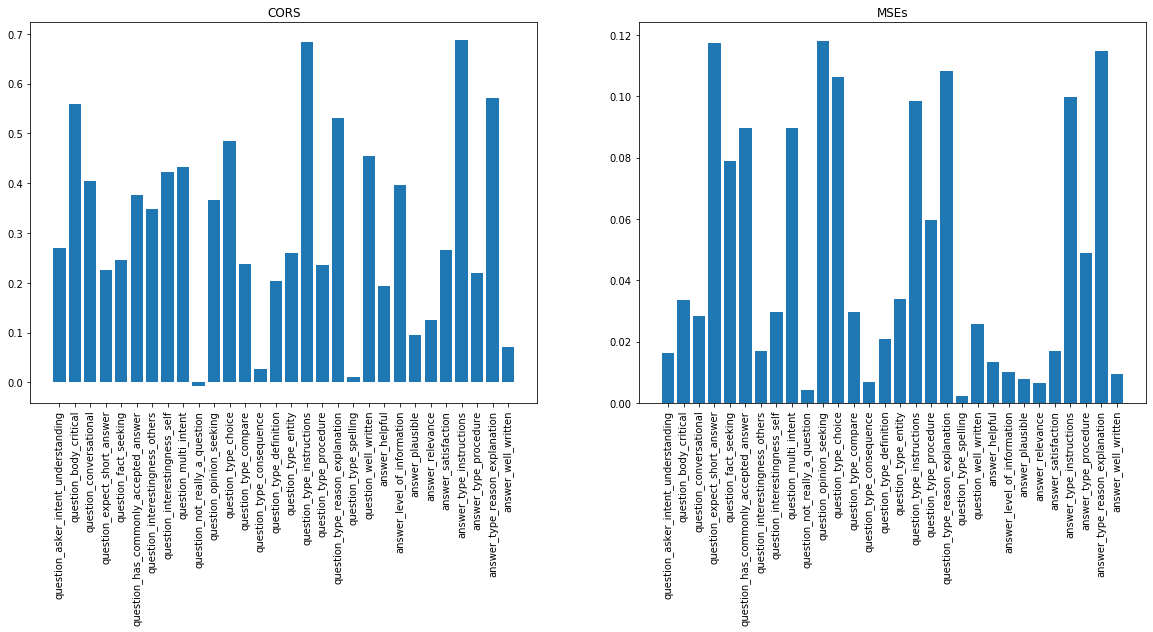

In [18]:
plot_cors_mse(target_names, preds_test, y_test)

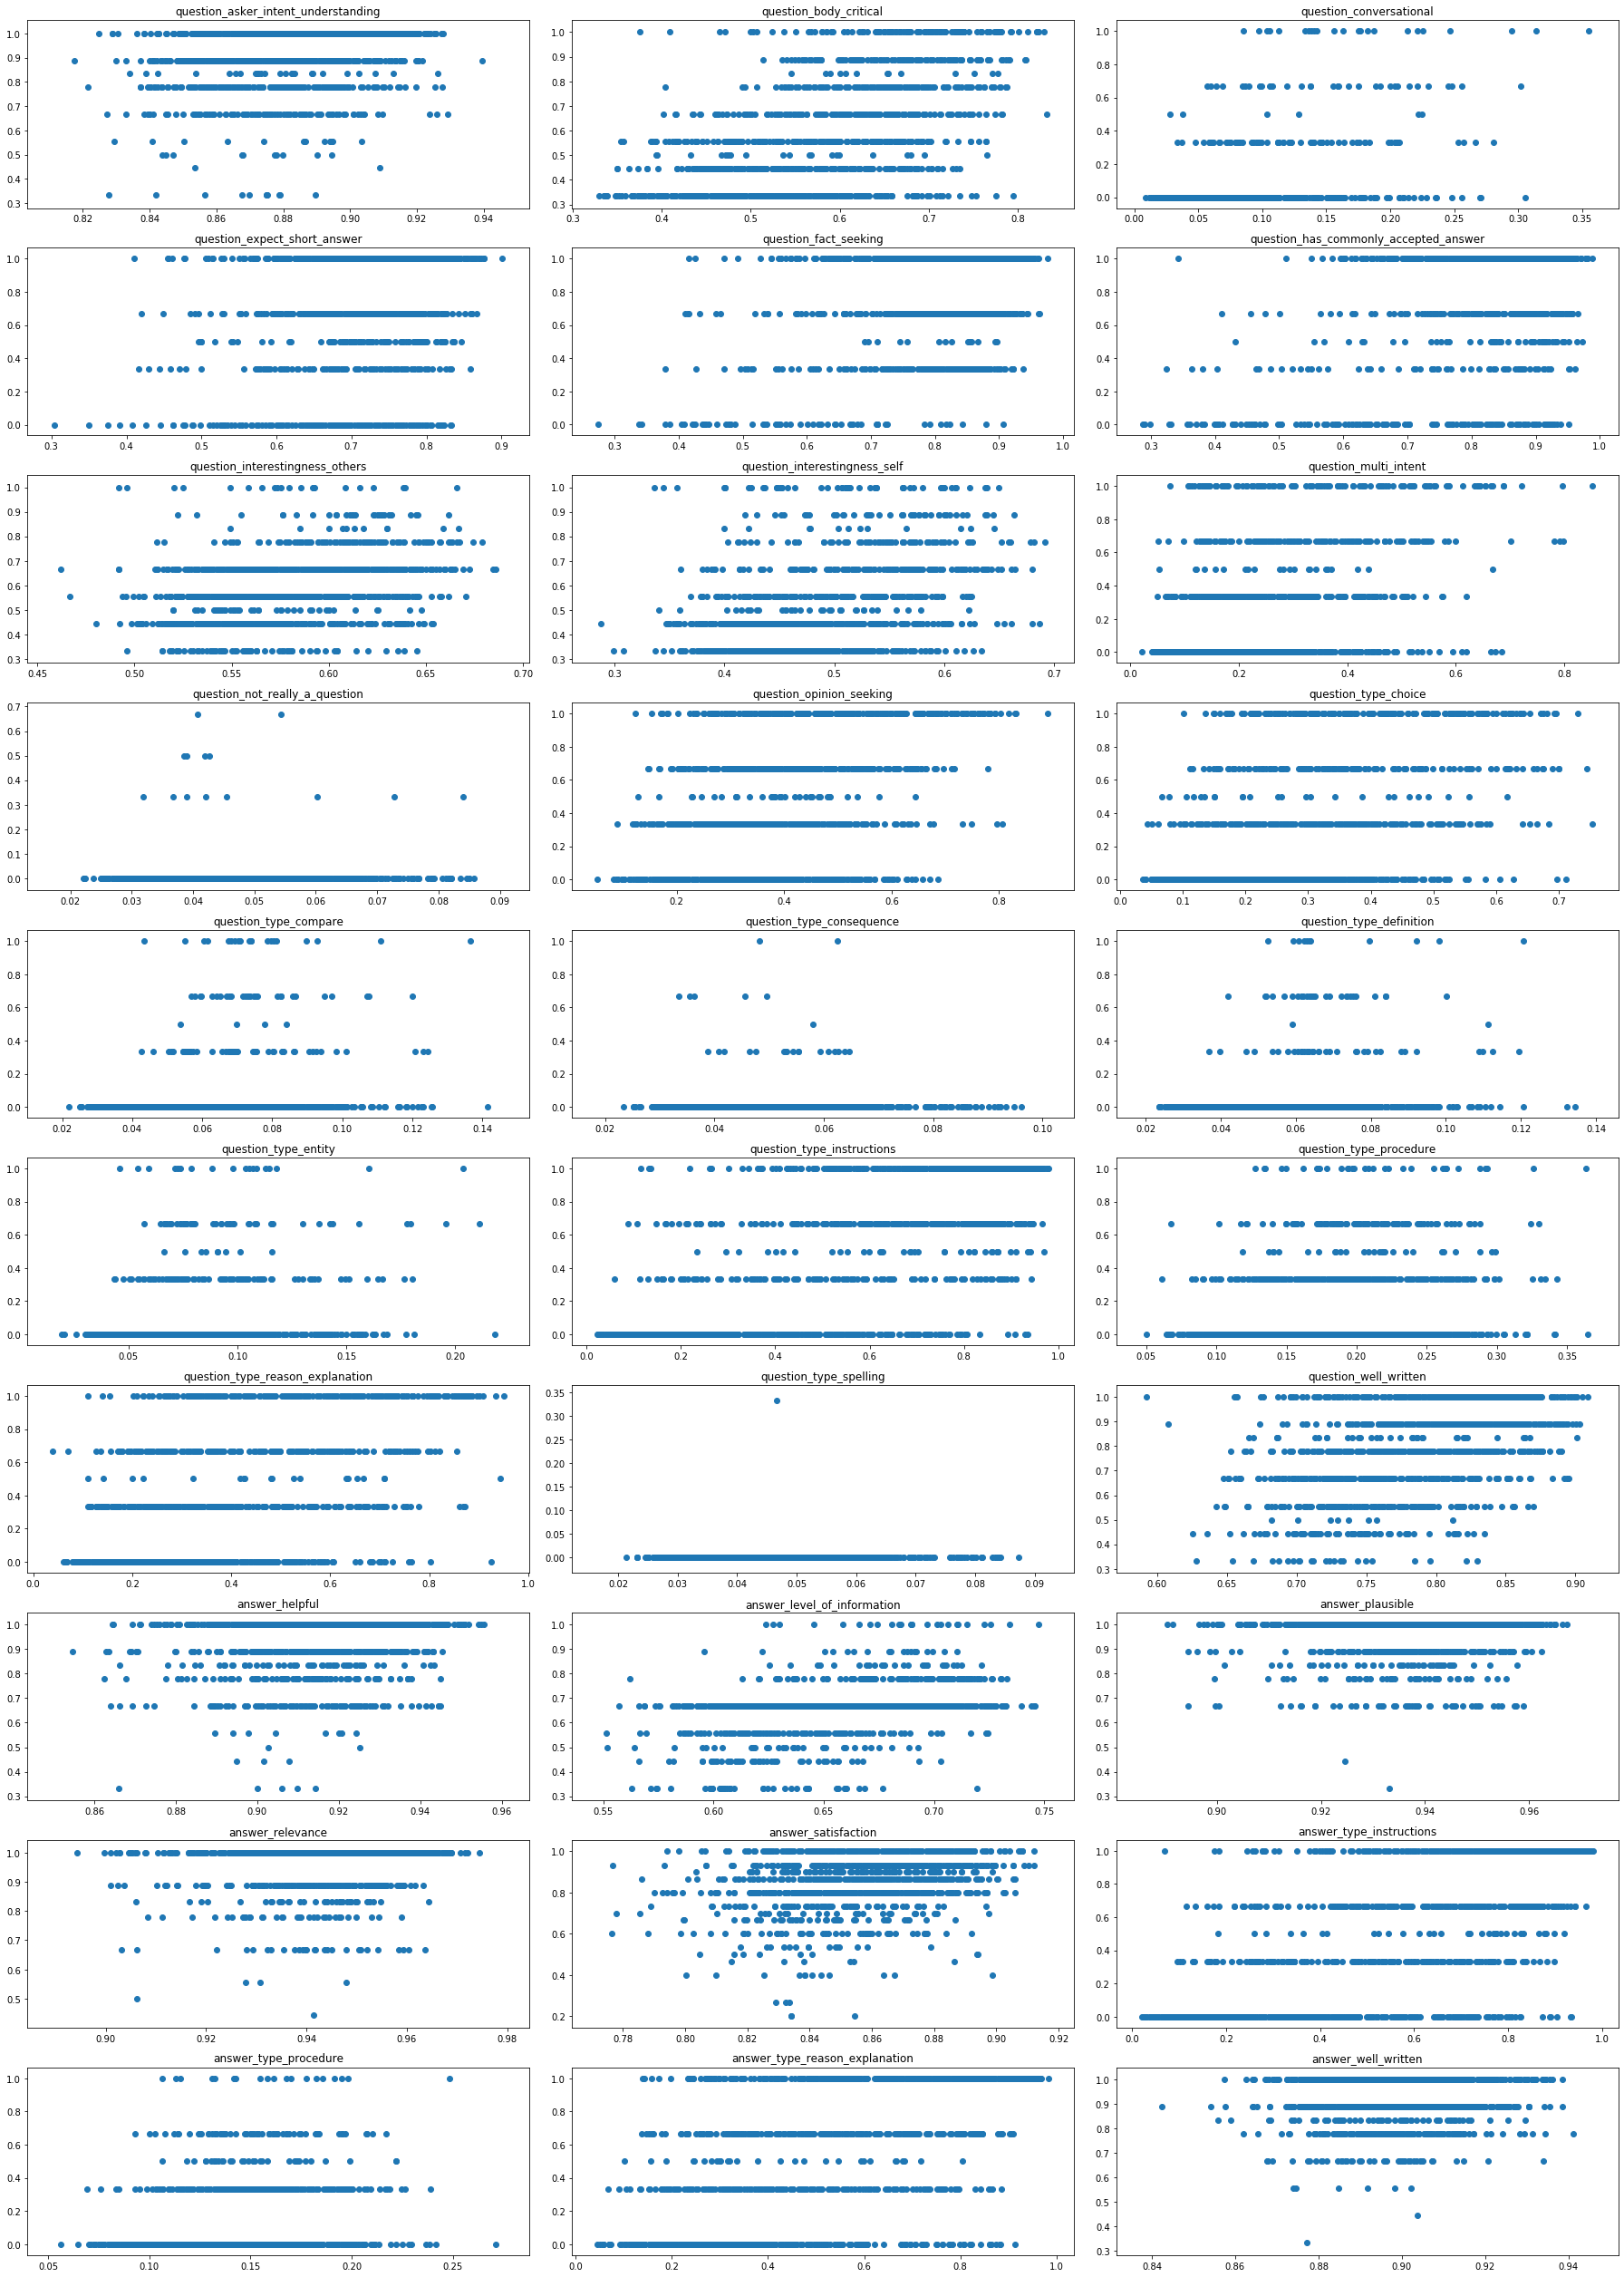

In [19]:
scatterplots(target_names, preds_test, y_test)

### Random forest regressors

In [18]:
model2 = keras.models.Model(model.input, model.get_layer('concatenate').output)

In [16]:
model2.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 300)]    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 500, 300)]   0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 500, 300)]   0                                            
__________________________________________________________________________________________________
attention (Attention)           (None, 32, 300)      0           input_1[0][0]                    
                                                                 input_1[0][0]         

In [19]:
X_train_rf = model2.predict([X_t_train, X_q_train, X_a_train])
X_test_rf = model2.predict([X_t_test, X_q_test, X_a_test])

In [20]:
X_train_rf.shape, X_test_rf.shape

((4860, 170), (1216, 170))

In [30]:
from sklearn.ensemble import RandomForestRegressor

In [47]:
rf = RandomForestRegressor(max_depth=5, n_jobs=-1)

In [21]:
from lightgbm import LGBMRegressor

reg = LGBMRegressor(learning_rate=0.005, n_estimators=500, reg_alpha=0.5, n_jobs=-1, max_depth=4)

In [22]:
preds_rf_train = []
preds_rf_test = []

for i in range(len(target_names)):
    
    y = y_train[:,i]
    
    reg.fit(X_train_rf, y)

    preds_rf_train.append(reg.predict(X_train_rf))
    preds_rf_test.append(reg.predict(X_test_rf))
    
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [23]:
preds_rf_train = np.array(preds_rf_train)
preds_rf_train = preds_rf_train.T

preds_rf_test = np.array(preds_rf_test)
preds_rf_test = preds_rf_test.T

In [24]:
print_cors_mse(target_names, preds_rf_test, y_test)

question_asker_intent_understanding:     cor: 0.306,    mse: 0.016
question_body_critical:                  cor: 0.576,    mse: 0.032
question_conversational:                 cor: 0.403,    mse: 0.026
question_expect_short_answer:            cor: 0.241,    mse: 0.117
question_fact_seeking:                   cor: 0.281,    mse: 0.076
question_has_commonly_accepted_answer:   cor: 0.383,    mse: 0.084
question_interestingness_others:         cor: 0.356,    mse: 0.017
question_interestingness_self:           cor: 0.426,    mse: 0.028
question_multi_intent:                   cor: 0.44,    mse: 0.089
question_not_really_a_question:          cor: 0.033,    mse: 0.002
question_opinion_seeking:                cor: 0.387,    mse: 0.114
question_type_choice:                    cor: 0.498,    mse: 0.1
question_type_compare:                   cor: 0.265,    mse: 0.027
question_type_consequence:               cor: 0.117,    mse: 0.005
question_type_definition:                cor: 0.319,    mse: 0.01

In [25]:
print_cors_mse(target_names, preds_rf_train, y_train)

question_asker_intent_understanding:     cor: 0.511,    mse: 0.014
question_body_critical:                  cor: 0.733,    mse: 0.023
question_conversational:                 cor: 0.455,    mse: 0.017
question_expect_short_answer:            cor: 0.51,    mse: 0.094
question_fact_seeking:                   cor: 0.532,    mse: 0.059
question_has_commonly_accepted_answer:   cor: 0.54,    mse: 0.066
question_interestingness_others:         cor: 0.494,    mse: 0.014
question_interestingness_self:           cor: 0.588,    mse: 0.022
question_multi_intent:                   cor: 0.627,    mse: 0.064
question_not_really_a_question:          cor: 0.171,    mse: 0.002
question_opinion_seeking:                cor: 0.608,    mse: 0.086
question_type_choice:                    cor: 0.659,    mse: 0.073
question_type_compare:                   cor: 0.361,    mse: 0.014
question_type_consequence:               cor: 0.23,    mse: 0.004
question_type_definition:                cor: 0.357,    mse: 0.00

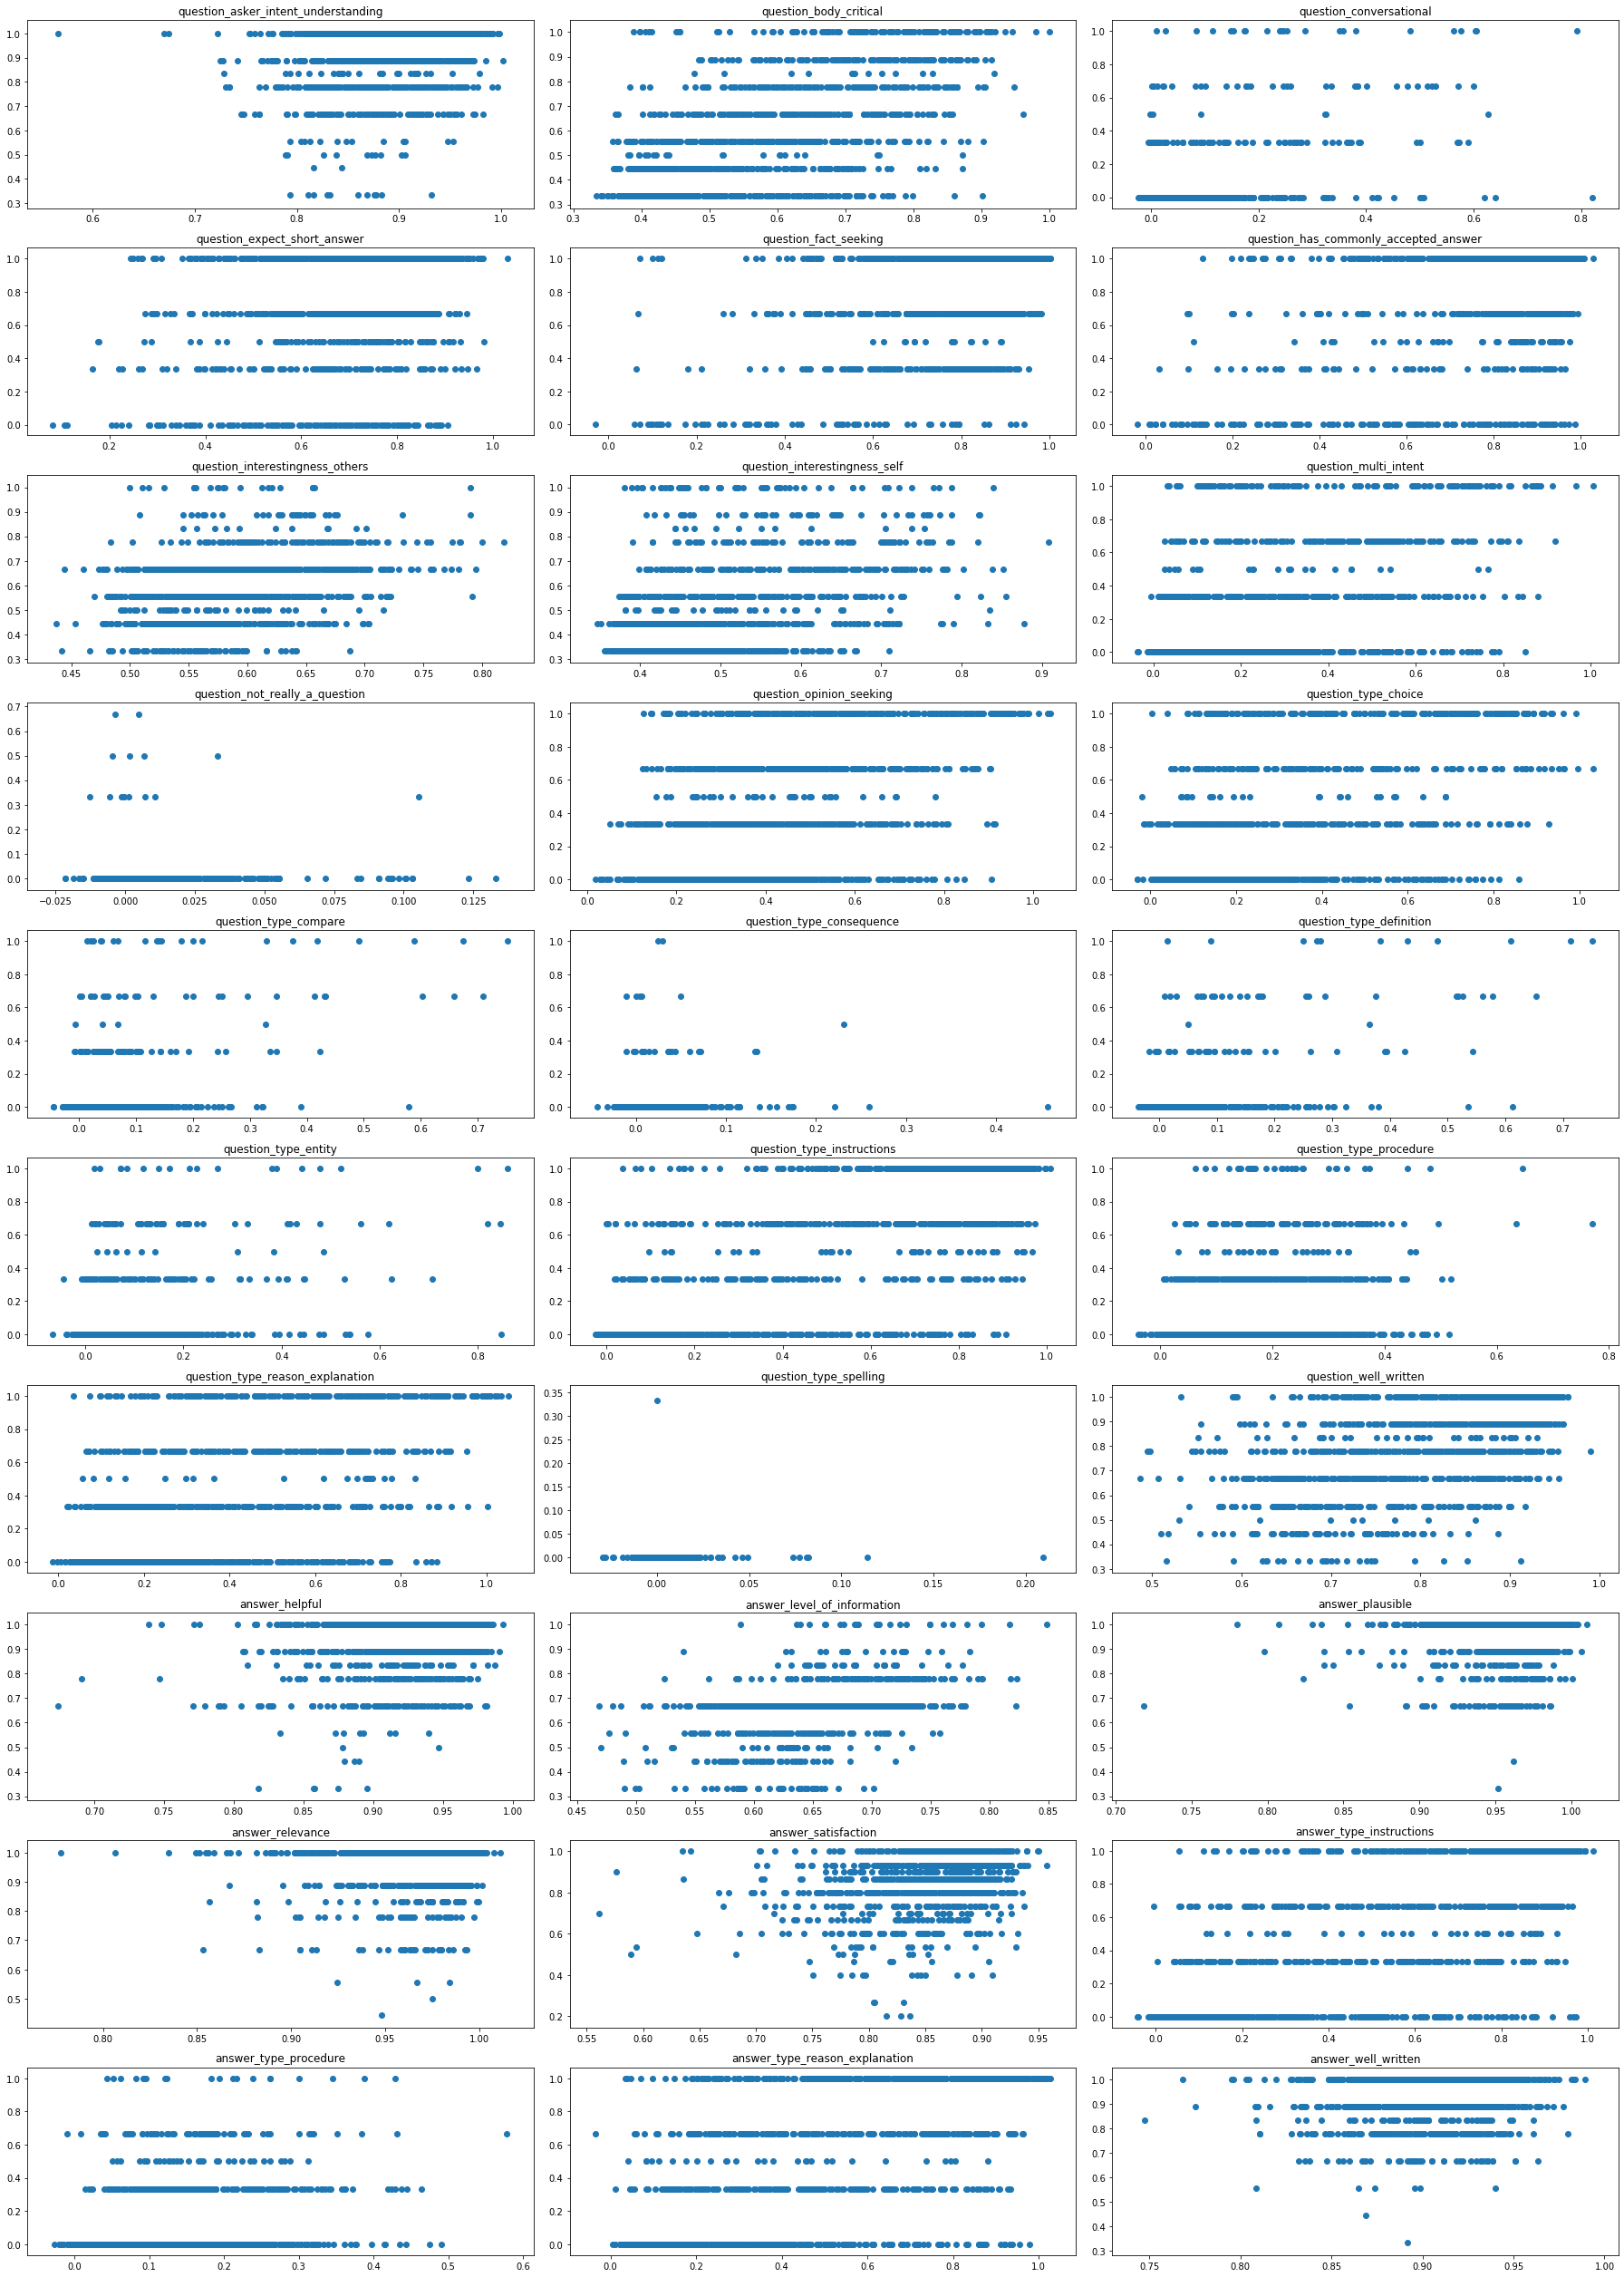

In [29]:
scatterplots(target_names, preds_rf_test, y_test)

In [ ]:
['question_not_really_a_question', 'question_type_spelling']

# Encoder like

In [16]:
input_q = keras.layers.Input(shape=(500,300))
x_q = keras.layers.Attention()([input_q,input_q])
x_q = keras.layers.Bidirectional(keras.layers.LSTM(128, dropout=0.3, return_sequences=True))(x_q)

input_a = keras.layers.Input(shape=(500,300))
x_a = keras.layers.Attention()([input_a,input_a])
x_a = keras.layers.Bidirectional(keras.layers.LSTM(128, dropout=0.3, return_sequences=True))(x_a)

x_q_a = keras.layers.Attention()([x_q,x_a])
x_q_a = keras.layers.Bidirectional(keras.layers.LSTM(128, dropout=0.3, return_sequences=True))(x_q_a)

x_a_q = keras.layers.Attention()([x_a,x_q])
x_a_q = keras.layers.Bidirectional(keras.layers.LSTM(128, dropout=0.3, return_sequences=True))(x_a_q)

x_q_a = keras.layers.Dropout(0.4)(x_q_a)
x_q_a = keras.layers.Dense(256, activity_regularizer='l2')(x_q_a)
x_q_a = keras.layers.LeakyReLU(0.5)(x_q_a)

x_a_q = keras.layers.Dropout(0.4)(x_a_q)
x_a_q = keras.layers.Dense(256, activity_regularizer='l2')(x_a_q)
x_a_q = keras.layers.LeakyReLU(0.5)(x_a_q)

x_q_a = attention_many_to_one()(x_q_a)
x_a_q = attention_many_to_one()(x_a_q)

x = keras.layers.concatenate((x_q_a, x_a_q))

x_a_q = keras.layers.Dropout(0.4)(x_a_q)
x_a_q = keras.layers.Dense(256, activity_regularizer='l2')(x_a_q)
x_a_q = keras.layers.LeakyReLU(0.5)(x_a_q)

output = keras.layers.Dense(30, activation=keras.activations.hard_sigmoid)(x)

model = keras.Model([input_q, input_a], output)

model.compile(optimizer = 'adam', loss = 'mse')

In [17]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 500, 300)]   0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 500, 300)]   0                                            
__________________________________________________________________________________________________
attention_4 (Attention)         (None, 500, 300)     0           input_3[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
attention_5 (Attention)         (None, 500, 300)     0           input_4[0][0]         

In [ ]:
model.fit([X_q_train, X_a_train], y_train, batch_size=145, epochs=500, callbacks=[earlystopping], validation_data=([X_q_test, X_a_test], y_test))

In [19]:
preds_train = model.predict([X_q_train, X_a_train])
preds_test = model.predict([X_q_test, X_a_test])

In [20]:
print_cors_mse(target_names, preds_test, y_test)

question_asker_intent_understanding:     cor: -0.058,    mse: 0.019
question_body_critical:                  cor: 0.218,    mse: 0.047
question_conversational:                 cor: 0.372,    mse: 0.034
question_expect_short_answer:            cor: 0.1,    mse: 0.124
question_fact_seeking:                   cor: 0.075,    mse: 0.089
question_has_commonly_accepted_answer:   cor: 0.325,    mse: 0.111
question_interestingness_others:         cor: 0.29,    mse: 0.018
question_interestingness_self:           cor: 0.338,    mse: 0.032
question_multi_intent:                   cor: 0.301,    mse: 0.108
question_not_really_a_question:          cor: -0.006,    mse: 0.007
question_opinion_seeking:                cor: 0.206,    mse: 0.138
question_type_choice:                    cor: 0.217,    mse: 0.136
question_type_compare:                   cor: 0.209,    mse: 0.031
question_type_consequence:               cor: 0.06,    mse: 0.01
question_type_definition:                cor: 0.144,    mse: 0.02

# No LSTM

In [15]:
input_q = keras.layers.Input(shape=(500,300))
x_q = keras.layers.Attention()([input_q,input_q])
#x_q = keras.layers.Bidirectional(keras.layers.LSTM(128, dropout=0.3, return_sequences=True))(x_q)
x_q = keras.layers.Dropout(0.4)(x_q)
x_q = keras.layers.Dense(256, activity_regularizer='l2')(x_q)
x_q = keras.layers.LeakyReLU(0.5)(x_q)


input_a = keras.layers.Input(shape=(500,300))
x_a = keras.layers.Attention()([input_a,input_a])
#x_a = keras.layers.Bidirectional(keras.layers.LSTM(128, dropout=0.3, return_sequences=True))(x_a)
x_a = keras.layers.Dropout(0.4)(x_a)
x_a = keras.layers.Dense(256, activity_regularizer='l2')(x_a)
x_a = keras.layers.LeakyReLU(0.5)(x_a)

x_q_a = keras.layers.Attention()([x_q,x_a])
#x_q_a = keras.layers.Bidirectional(keras.layers.LSTM(128, dropout=0.3, return_sequences=True))(x_q_a)

x_a_q = keras.layers.Attention()([x_a,x_q])
#x_a_q = keras.layers.Bidirectional(keras.layers.LSTM(128, dropout=0.3, return_sequences=True))(x_a_q)

x_q_a = keras.layers.Dropout(0.4)(x_q_a)
x_q_a = keras.layers.Dense(256, activity_regularizer='l2')(x_q_a)
x_q_a = keras.layers.LeakyReLU(0.5)(x_q_a)

x_a_q = keras.layers.Dropout(0.4)(x_a_q)
x_a_q = keras.layers.Dense(256, activity_regularizer='l2')(x_a_q)
x_a_q = keras.layers.LeakyReLU(0.5)(x_a_q)

x_q_a = attention_many_to_one()(x_q_a)
x_a_q = attention_many_to_one()(x_a_q)

x = keras.layers.concatenate((x_q_a, x_a_q))

x_a_q = keras.layers.Dropout(0.4)(x_a_q)
x_a_q = keras.layers.Dense(256, activity_regularizer='l2')(x_a_q)
x_a_q = keras.layers.LeakyReLU(0.5)(x_a_q)

output = keras.layers.Dense(30, activation=keras.activations.hard_sigmoid)(x)

model = keras.Model([input_q, input_a], output)

model.compile(optimizer = 'adam', loss = 'mse')

In [16]:
model.fit([X_q_train, X_a_train], y_train, batch_size=145, epochs=500, callbacks=[earlystopping], validation_data=([X_q_test, X_a_test], y_test))

Epoch 1/500
34/34 [==============================] - 14s 419ms/step - loss: 3.0113 - val_loss: 0.6073
Epoch 2/500
34/34 [==============================] - 13s 383ms/step - loss: 1.5500 - val_loss: 0.3843
Epoch 3/500
34/34 [==============================] - 13s 379ms/step - loss: 0.9782 - val_loss: 0.2868
Epoch 4/500
34/34 [==============================] - 13s 385ms/step - loss: 0.6515 - val_loss: 0.2330
Epoch 5/500
34/34 [==============================] - 13s 371ms/step - loss: 0.4603 - val_loss: 0.2006
Epoch 6/500
34/34 [==============================] - 13s 368ms/step - loss: 0.3451 - val_loss: 0.1798
Epoch 7/500
34/34 [==============================] - 13s 388ms/step - loss: 0.2736 - val_loss: 0.1653
Epoch 8/500
34/34 [==============================] - 13s 372ms/step - loss: 0.2271 - val_loss: 0.1548
Epoch 9/500
34/34 [==============================] - 13s 377ms/step - loss: 0.1958 - val_loss: 0.1462
Epoch 10/500
34/34 [==============================] - 13s 394ms/step - loss: 0.173

In [17]:
preds_train = model.predict([X_q_train, X_a_train])
preds_test = model.predict([X_q_test, X_a_test])

In [19]:
print_cors_mse(target_names, preds_test, y_test)

question_asker_intent_understanding:     cor: -0.04,    mse: 0.02
question_body_critical:                  cor: 0.048,    mse: 0.048
question_conversational:                 cor: 0.291,    mse: 0.038
question_expect_short_answer:            cor: 0.177,    mse: 0.125
question_fact_seeking:                   cor: 0.082,    mse: 0.09
question_has_commonly_accepted_answer:   cor: 0.295,    mse: 0.115
question_interestingness_others:         cor: -0.171,    mse: 0.019
question_interestingness_self:           cor: 0.266,    mse: 0.035
question_multi_intent:                   cor: 0.284,    mse: 0.112
question_not_really_a_question:          cor: 0.005,    mse: 0.011
question_opinion_seeking:                cor: 0.143,    mse: 0.138
question_type_choice:                    cor: 0.138,    mse: 0.139
question_type_compare:                   cor: 0.118,    mse: 0.034
question_type_consequence:               cor: 0.071,    mse: 0.013
question_type_definition:                cor: 0.087,    mse: 0.

In [19]:
print_cors_mse(target_names, preds_train, y_train)

question_asker_intent_understanding:     cor: 0.439,    mse: 0.016
question_body_critical:                  cor: 0.556,    mse: 0.04
question_conversational:                 cor: 0.514,    mse: 0.026
question_expect_short_answer:            cor: 0.49,    mse: 0.109
question_fact_seeking:                   cor: 0.486,    mse: 0.078
question_has_commonly_accepted_answer:   cor: 0.519,    mse: 0.089
question_interestingness_others:         cor: 0.44,    mse: 0.016
question_interestingness_self:           cor: 0.576,    mse: 0.029
question_multi_intent:                   cor: 0.63,    mse: 0.088
question_not_really_a_question:          cor: 0.196,    mse: 0.002
question_opinion_seeking:                cor: 0.557,    mse: 0.114
question_type_choice:                    cor: 0.603,    mse: 0.111
question_type_compare:                   cor: 0.48,    mse: 0.019
question_type_consequence:               cor: 0.406,    mse: 0.005
question_type_definition:                cor: 0.655,    mse: 0.017


/usr/anaconda/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/anaconda/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/anaconda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/anaconda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/anaconda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


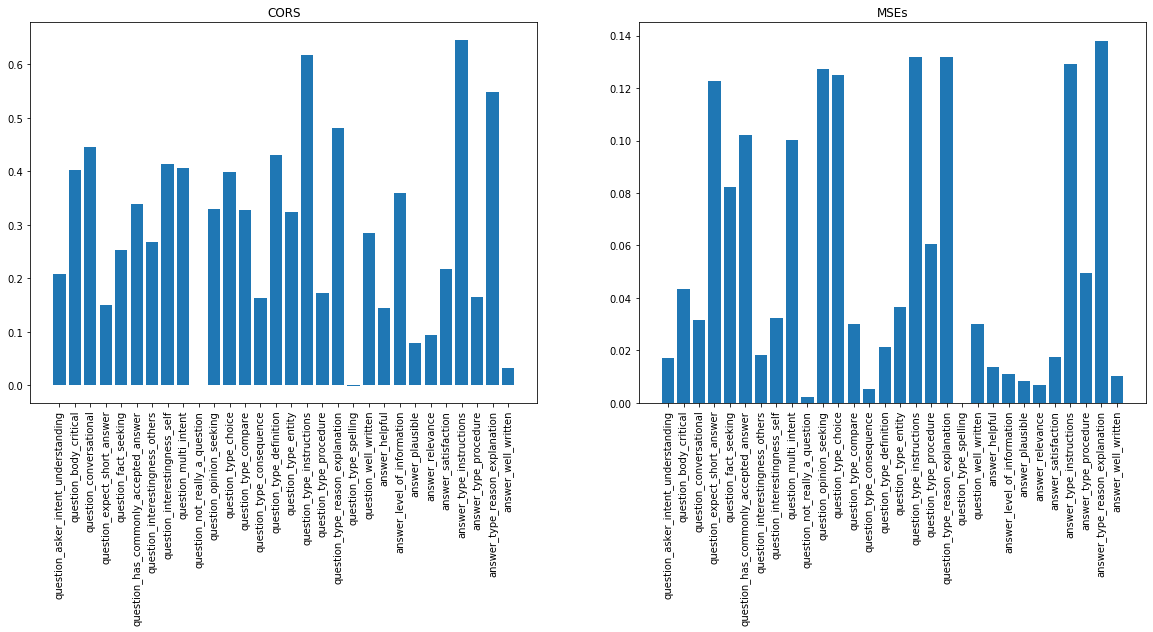

In [20]:
plot_cors_mse(target_names, preds_test, y_test)

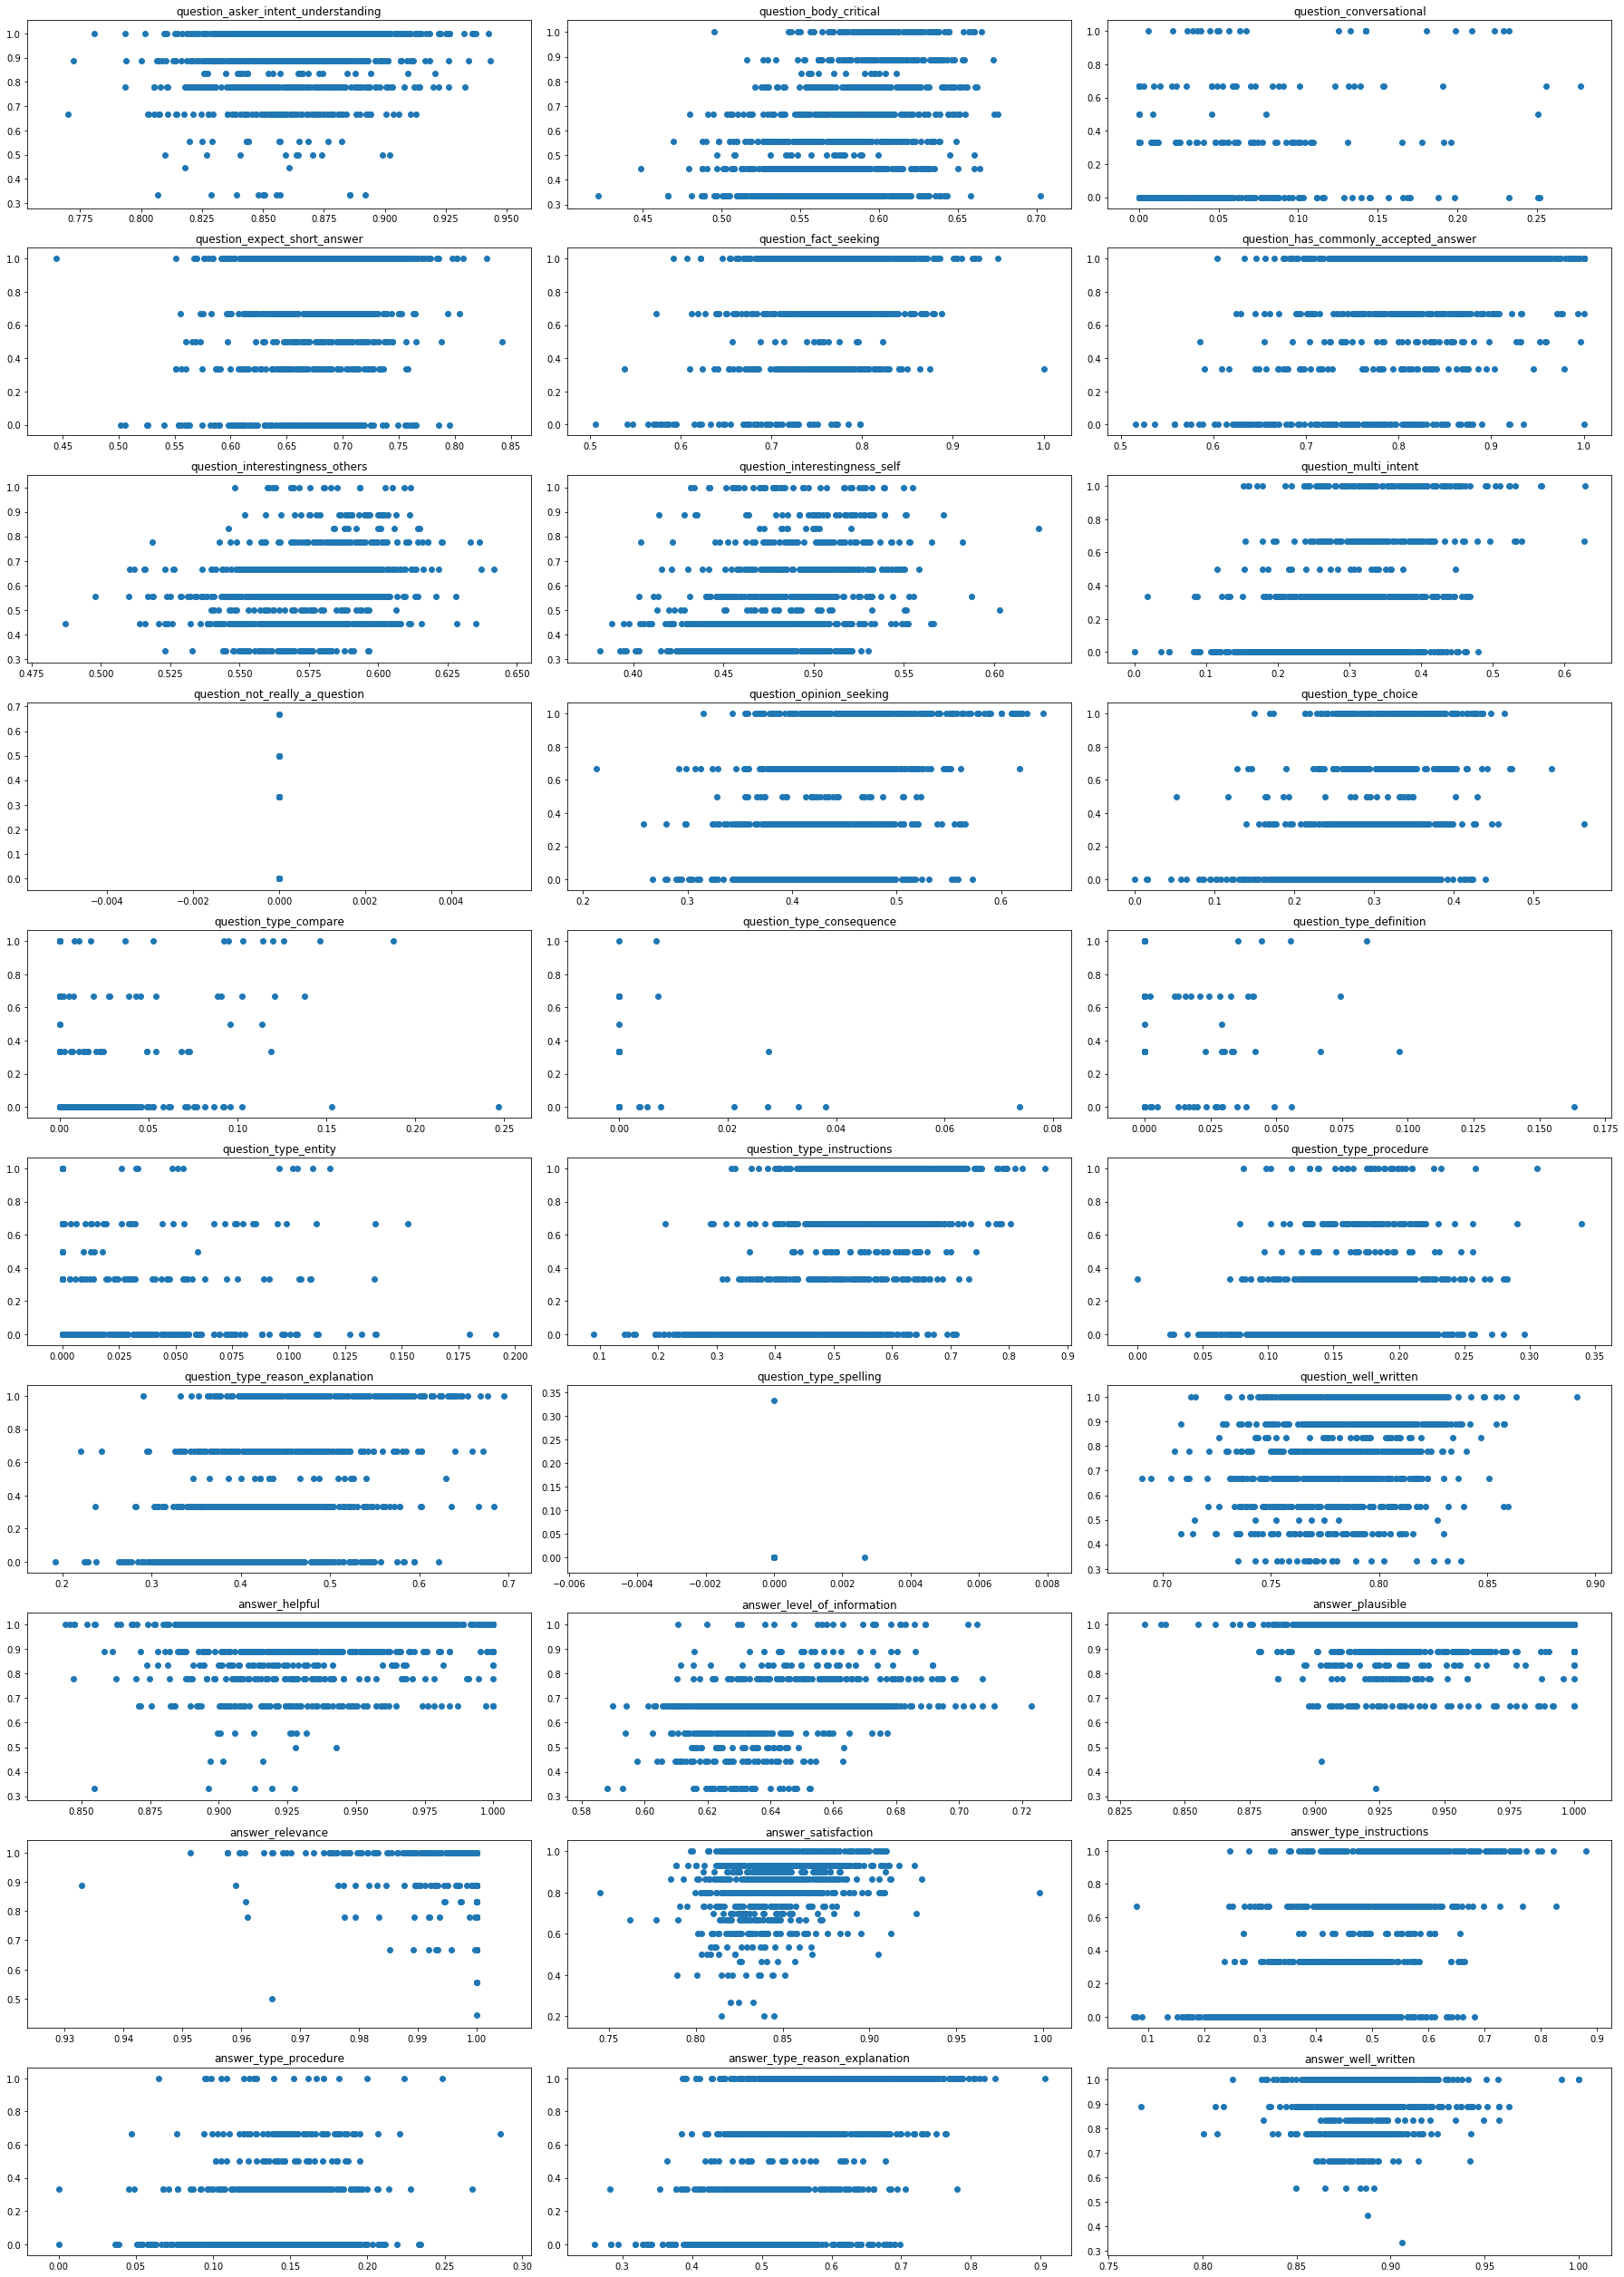

In [21]:
scatterplots(target_names, preds_test, y_test)